In [2]:
import numpy as np
import pandas as pd
from astropy.cosmology import Planck13 as cosmo
from astropy.io import fits
import fsps
from matplotlib.gridspec import GridSpec
from spec_tools import Source_present, Scale_model, Oldest_galaxy, Sig_int,Likelihood_contours, Median_w_Error_cont
from spec_exam import Gen_spec
from sim_engine import *
from spec_stats import Highest_density_region
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, interp2d
from glob import glob
import seaborn as sea
import os
from grizli import multifit
from grizli import model
from C_full_fit import Gen_spec2, Chi_Squared
from C_sim_test import Gen_sim, F_lam_per_M
from prospect.models.transforms import logsfr_ratios_to_masses

import dynesty
from dynesty import plotting as dyplot
from dynesty.utils import quantile as _quantile
from scipy.ndimage import gaussian_filter as norm_kde

import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
R = robjects.r
pandas2ri.activate()

from time import time
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.0, as_cmap=True)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### set home for files
hpath = os.environ['HOME'] + '/'

if hpath == '/Users/Vince.ec/':
    dpath = '/Volumes/Vince_research/Data/' 
    
else:
    dpath = hpath + 'Data/' 

In [3]:
def Get_posterior(results, entry):
    sample = results.samples[:, entry]
    logwt = results.logwt
    logz = results.logz
    
    
    weight = np.exp(logwt - logz[-1])

    q = [0.5 - 0.5 * 0.999999426697, 0.5 + 0.5 * 0.999999426697]
    span = _quantile(sample.T, q, weights=weight)

    s = 0.02

    bins = int(round(10. / 0.02))
    n, b = np.histogram(sample, bins=bins, weights=weight,
                        range=np.sort(span))
    n = norm_kde(n, 10.)
    x0 = 0.5 * (b[1:] + b[:-1])
    y0 = n
    
    return x0, y0 / np.trapz(y0,x0)

def convert_sfh(agebins, mformed, epsilon=1e-4, maxage=None):
    #### create time vector
    agebins_yrs = 10**agebins.T
    dt = agebins_yrs[1, :] - agebins_yrs[0, :]
    bin_edges = np.unique(agebins_yrs)
    if maxage is None:
        maxage = agebins_yrs.max()  # can replace maxage with something else, e.g. tuniv
    t = np.concatenate((bin_edges * (1.-epsilon), bin_edges * (1+epsilon)))
    t.sort()
    t = t[1:-1] # remove older than oldest bin, younger than youngest bin
    fsps_time = maxage - t

    #### calculate SFR at each t
    sfr = mformed / dt
    sfrout = np.zeros_like(t)
    sfrout[::2] = sfr
    sfrout[1::2] = sfr  # * (1+epsilon)

    return (fsps_time / 1e9)[::-1], sfrout[::-1], maxage / 1e9

In [4]:
specz = 1.25
lages = [0,9.0,9.1,9.2,9.3,9.4,9.5,9.6,9.7,9.8,9.9]

tuniv = Oldest_galaxy(specz)
nbins = len(lages) - 1

tbinmax = (tuniv * 0.85) * 1e9
lim1, lim2 = 7.4772, 8.0
agelims = [0,lim1] + np.linspace(lim2,np.log10(tbinmax),nbins-2).tolist() + [np.log10(tuniv*1e9)]
agebins = np.array([agelims[:-1], agelims[1:]]).T

In [5]:
lages2 = [0,8.0,8.3,8.6,9.0,9.3,9.6,10]

tuniv2 = Oldest_galaxy(specz)
nbins2 = len(lages2) - 1

tbinmax2 = (tuniv2 * 0.85) * 1e9
lim12, lim22 = 7.4772, 8.0
agelims2 = [0,lim12] + np.linspace(lim22,np.log10(tbinmax2),nbins2-2).tolist() + [np.log10(tuniv2*1e9)]
agebins2 = np.array([agelims2[:-1], agelims2[1:]]).T

# Compare bounding method for tab to delay and tab to tab

In [11]:
## logL

tdL = []
ttL = []
tt_lbL = []
tt_smL = []
tt_ssL = []

for i in range(1,6,1):
    bfit = np.load('../data/bestfits/sim_test_tab_to_delay_multi_{0}_bfit.npy'.format(i))
    tdL.append(bfit[-1])
    
    bfit = np.load('../data/bestfits/sim_test_tab_to_tab_{0}_bfit.npy'.format(i))
    ttL.append(bfit[-1])
    
    bfit = np.load('../data/bestfits/sim_test_tab_to_tab_lessbin_{0}_bfit.npy'.format(i))
    tt_lbL.append(bfit[-1])
    
    bfit = np.load('../data/bestfits/sim_test_tab_to_tab_sclmass_{0}_bfit.npy'.format(i))
    tt_smL.append(bfit[-1])
    
    bfit = np.load('../data/bestfits/sim_test_tab_to_tab_sclspec_{0}_bfit.npy'.format(i))
    tt_ssL.append(bfit[-1])


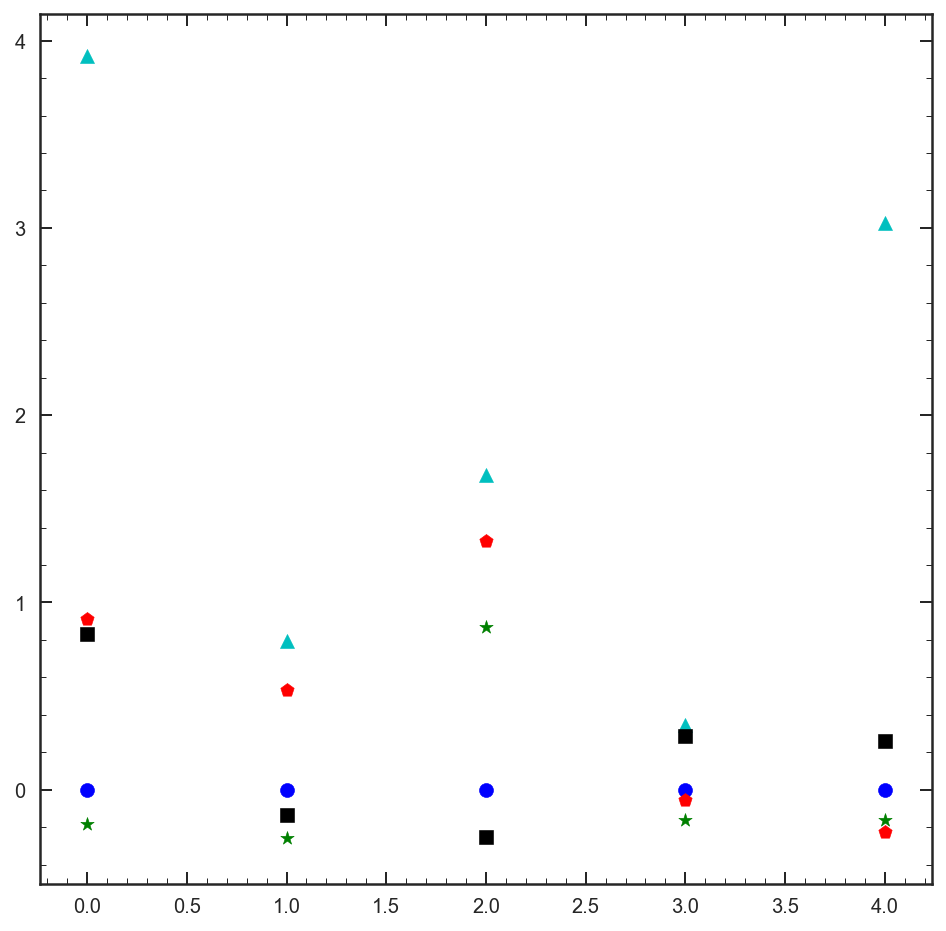

In [13]:
plt.figure(figsize=[8,8])
plt.scatter(range(len(tdL)),np.abs(tdL) - np.abs(tdL),color='b', marker = 'o')
plt.scatter(range(len(ttL)),np.abs(ttL) - np.abs(tdL),color='r', marker = 'p')
plt.scatter(range(len(tt_lbL)),np.abs(tt_lbL) - np.abs(tdL),color='c', marker = '^')
plt.scatter(range(len(tt_smL)),np.abs(tt_smL) - np.abs(tdL),color='g', marker = '*')
plt.scatter(range(len(tt_ssL)),np.abs(tt_ssL) - np.abs(tdL),color='k', marker = 's')

# plt.plot([-155,-120],[-155,-120])

In [9]:
sp = fsps.StellarPopulation(imf_type = 2, tpagb_norm_type=0, zcontinuous = 1, logzsol = np.log10(0.8), sfh = 3, dust_type = 1)
sp.params['compute_light_ages'] = True

tab_masses = np.array([0.00, 0.00, 0.000, 0.0000, 0.0001, 0.0001, 0.001, 0.025, 0.3, 0.9])
sp.params['dust2'] =0.2
sp.params['dust1'] =0.2
time, sfr, tmax = convert_sfh(agebins, tab_masses)

sp.set_tabular_sfh(time,sfr)
lwa_tab = sp.get_mags(tage = 4.25, bands=['sdss_g'])
    
sp.params['compute_light_ages'] = False

# Compare bounding method for delay to tab

In [15]:
ddL = []
dtL = []
dt_lbL = []
dt_smL = []
dt_ssL = []

for i in range(1,6,1):  
    bfit = np.load('../data/bestfits/sim_test_delay_to_delay_multi_{0}_bfit.npy'.format(i))
    ddL.append(bfit[-1])
    
    bfit = np.load('../data/bestfits/sim_test_delay_to_tab_{0}_bfit.npy'.format(i))
    dtL.append(bfit[-1])
    
    bfit = np.load('../data/bestfits/sim_test_delay_to_tab_lessbin_{0}_bfit.npy'.format(i))
    dt_lbL.append(bfit[-1])
    
    bfit = np.load('../data/bestfits/sim_test_delay_to_tab_sclmass_{0}_bfit.npy'.format(i))
    dt_smL.append(bfit[-1])
    
    bfit = np.load('../data/bestfits/sim_test_delay_to_tab_sclspec_{0}_bfit.npy'.format(i))
    dt_ssL.append(bfit[-1])

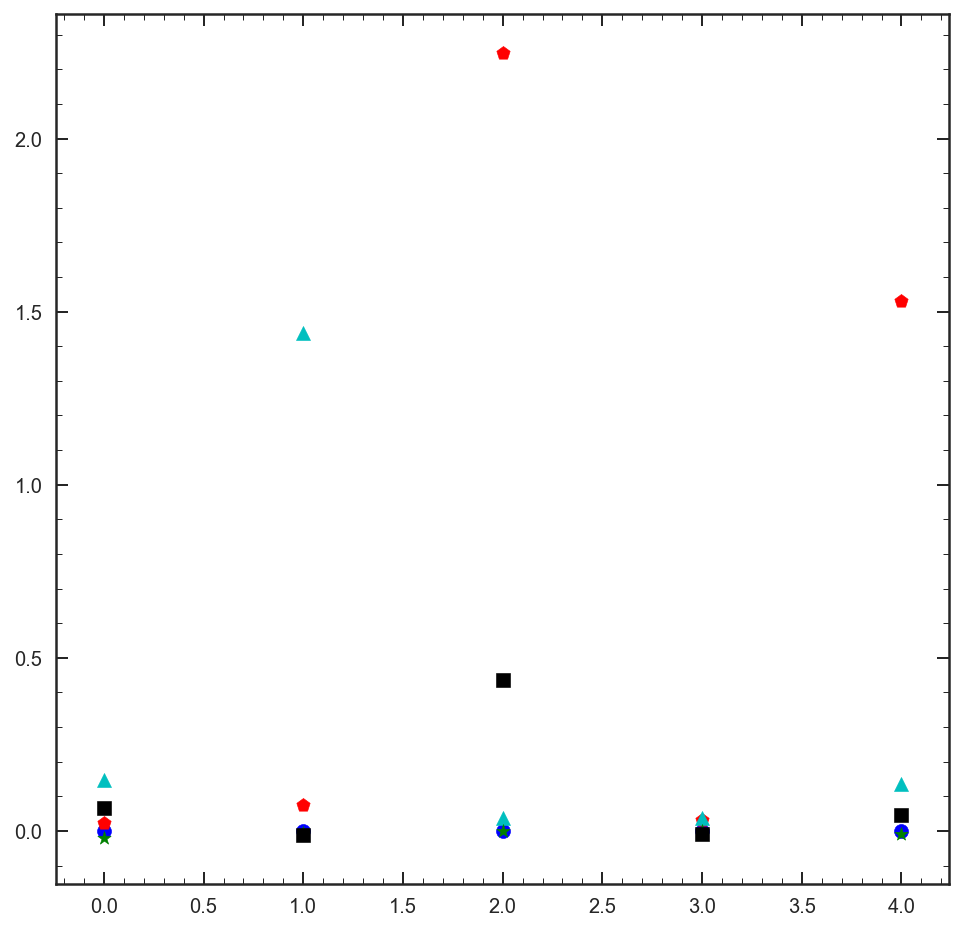

In [20]:
plt.figure(figsize=[8,8])
plt.scatter(range(len(ddL)),np.abs(ddL) - np.abs(ddL),color='b', marker = 'o')
plt.scatter(range(len(dtL)),np.abs(dtL) - np.abs(ddL),color='r', marker = 'p')
plt.scatter(range(len(dt_lbL)),np.abs(dt_lbL) - np.abs(ddL),color='c', marker = '^')
plt.scatter(range(len(dt_smL)),np.abs(dt_smL) - np.abs(ddL),color='g', marker = '*')
plt.scatter(range(len(dt_ssL)),np.abs(dt_ssL) - np.abs(ddL),color='k', marker = 's')

# plt.plot([-155,-120],[-155,-120])

In [21]:
sp = fsps.StellarPopulation(imf_type = 2, tpagb_norm_type=0, zcontinuous = 1, logzsol = np.log10(1), sfh = 4, tau=0.1, dust_type = 1)
sp.params['compute_light_ages'] = True

sp.params['dust2'] =0.2
sp.params['dust1'] =0.2
sp.params['tau'] =0.3
sp.params['logzsol'] = np.log10(0.8)

lwa_delay = sp.get_mags(tage = 4.25, bands=['sdss_g'])
    
sp.params['compute_light_ages'] = False

# Compare td spec_fits

In [23]:
sp = fsps.StellarPopulation(imf_type = 2, tpagb_norm_type=0, zcontinuous = 1, logzsol = np.log10(0.8), sfh = 3, dust_type = 1)

tab_masses = np.array([0.00, 0.00, 0.000, 0.0000, 0.0001, 0.0001, 0.001, 0.025, 0.3, 0.9])
sp.params['dust2'] =0.2
sp.params['dust1'] =0.2
time, sfr, tmax = convert_sfh(agebins, tab_masses)

sp.set_tabular_sfh(time,sfr)

wave1, flux1 = sp.get_spectrum(tage = 4.25, peraa = True)

mass_perc1 = sp.stellar_mass
 
D_l = cosmo.luminosity_distance(specz).value # in Mpc
conv = 3.086E24
lsol_to_fsol = 3.839E33

mass_transform = (10**11 / mass_perc1) * lsol_to_fsol / (4 * np.pi * (D_l*conv)**2)

(2.8, 5)

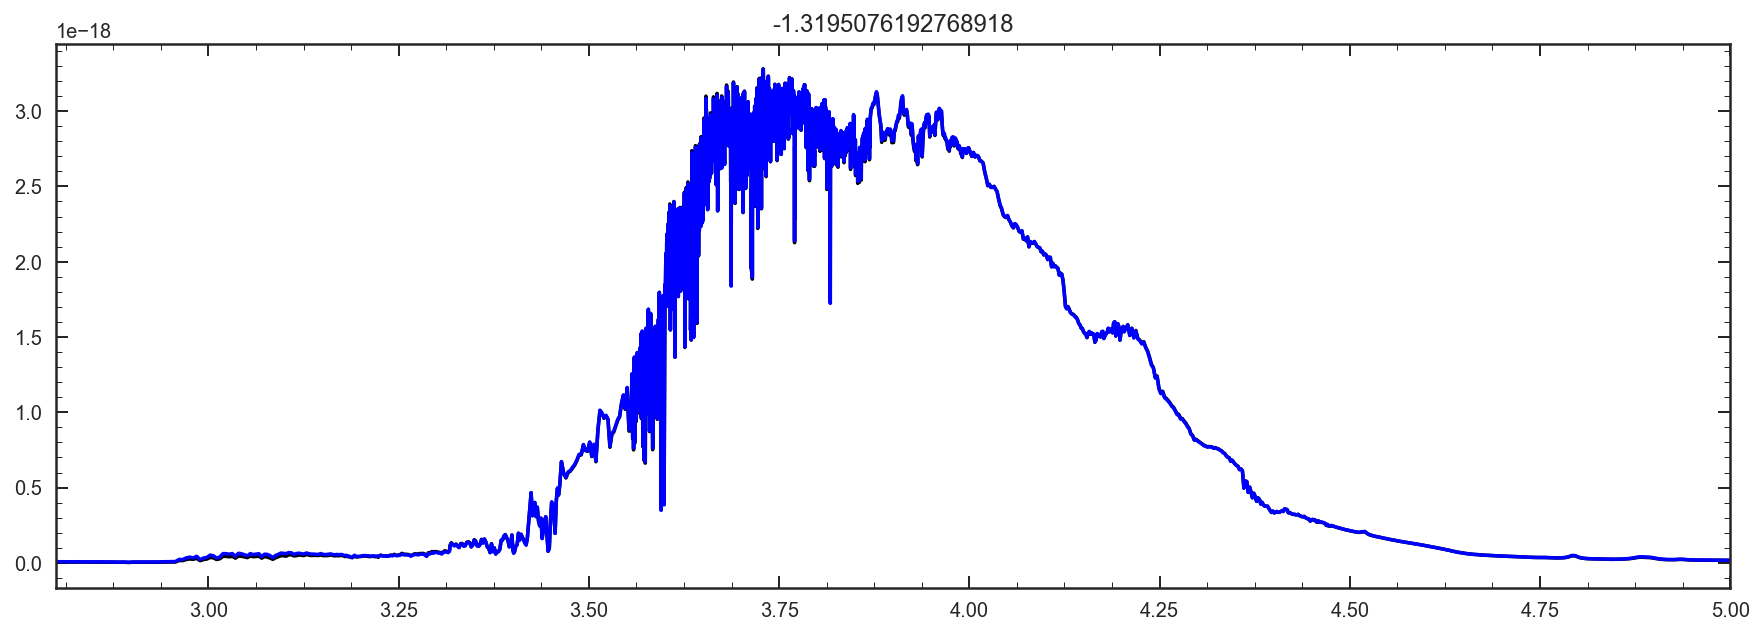

In [26]:
sp = fsps.StellarPopulation(imf_type = 2, tpagb_norm_type=0, zcontinuous = 1, logzsol = np.log10(0.8), sfh = 3, dust_type = 1)


bfZ, bft, bfm1, bfm2, bfm3, bfm4, bfm5, bfm6, \
bfm7, bfm8, bfm9, bfm10, bfz, bfd, bflm, logl = \
np.load('../data/bestfits/sim_test_tab_to_tab_1_bfit.npy')

sp.params['dust2'] = bfd
sp.params['dust1'] = bfd
sp.params['logzsol'] = np.log10(bfZ)

time, sfr, tmax = convert_sfh(agebins,[bfm1, bfm2,bfm3, bfm4, bfm5, bfm6,bfm7, bfm8, bfm9, bfm10])

sp.set_tabular_sfh(time,sfr)

wave, flux = sp.get_spectrum(tage = bft, peraa = True)

mp1 = sp.stellar_mass

D_l = cosmo.luminosity_distance(bfz).value # in Mpc
MT = (10**bflm / mp1) * lsol_to_fsol / (4 * np.pi * (D_l*conv)**2)

plt.figure(figsize=[15,5])
plt.plot(np.log10(wave1), flux1 * mass_transform,'k')
plt.plot(np.log10(wave), flux * MT,'b')
plt.title(logl)
plt.xlim(2.8,5)

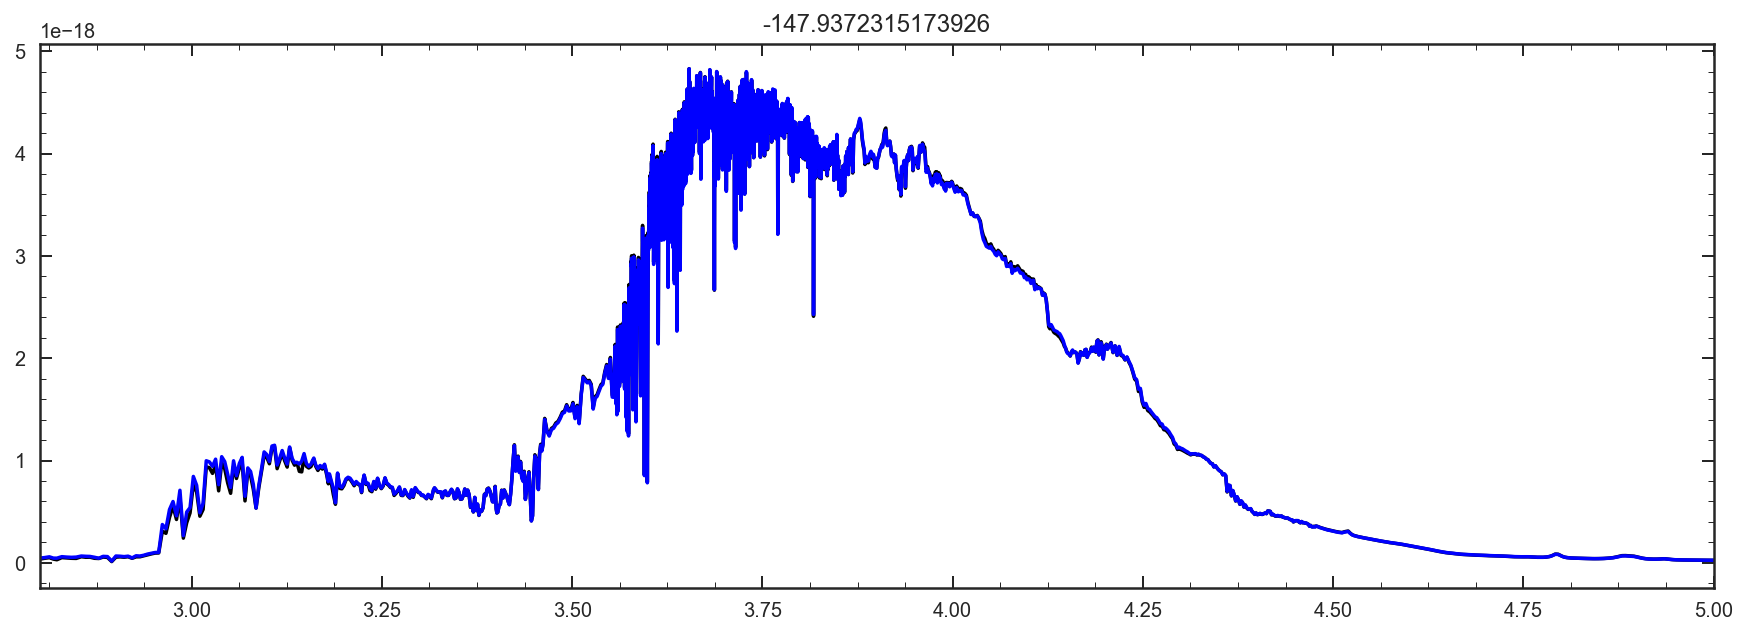

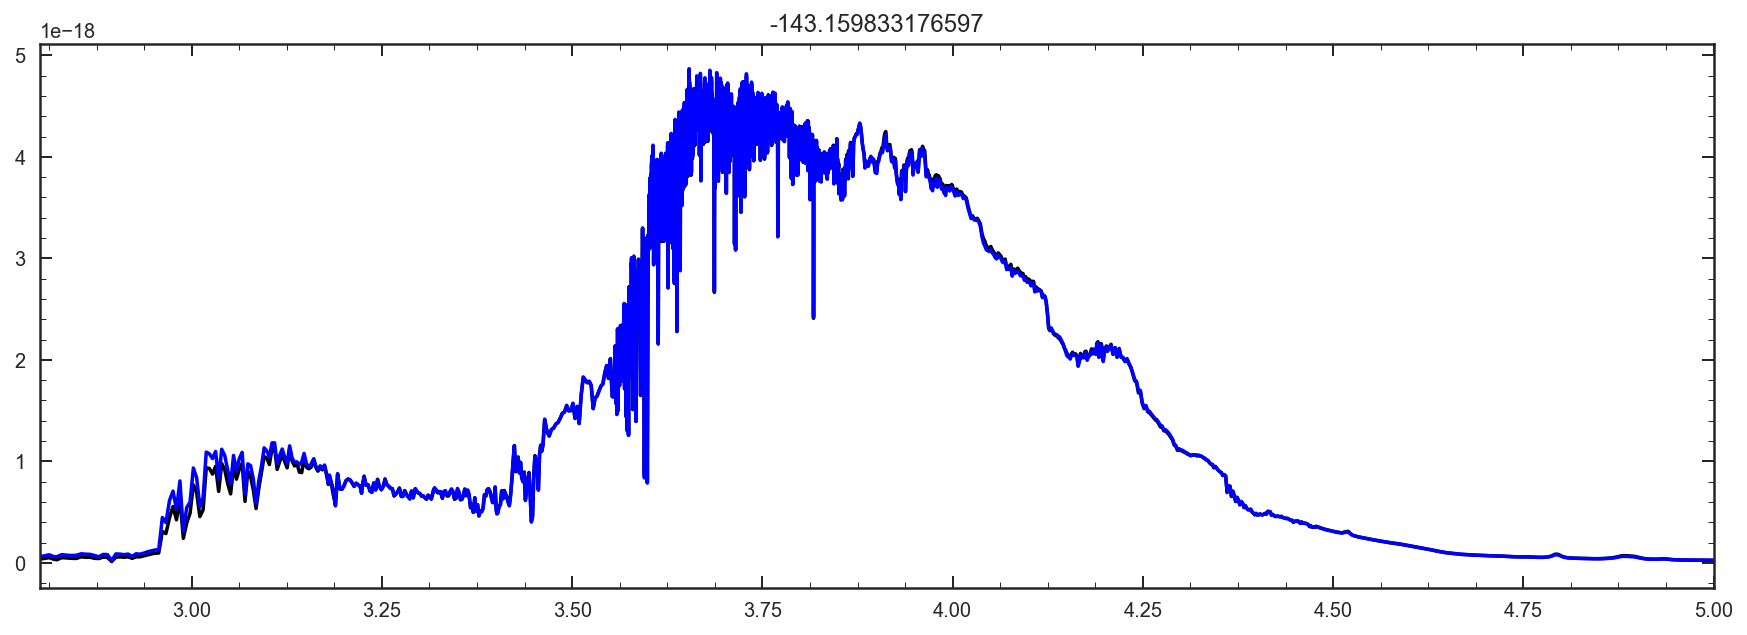

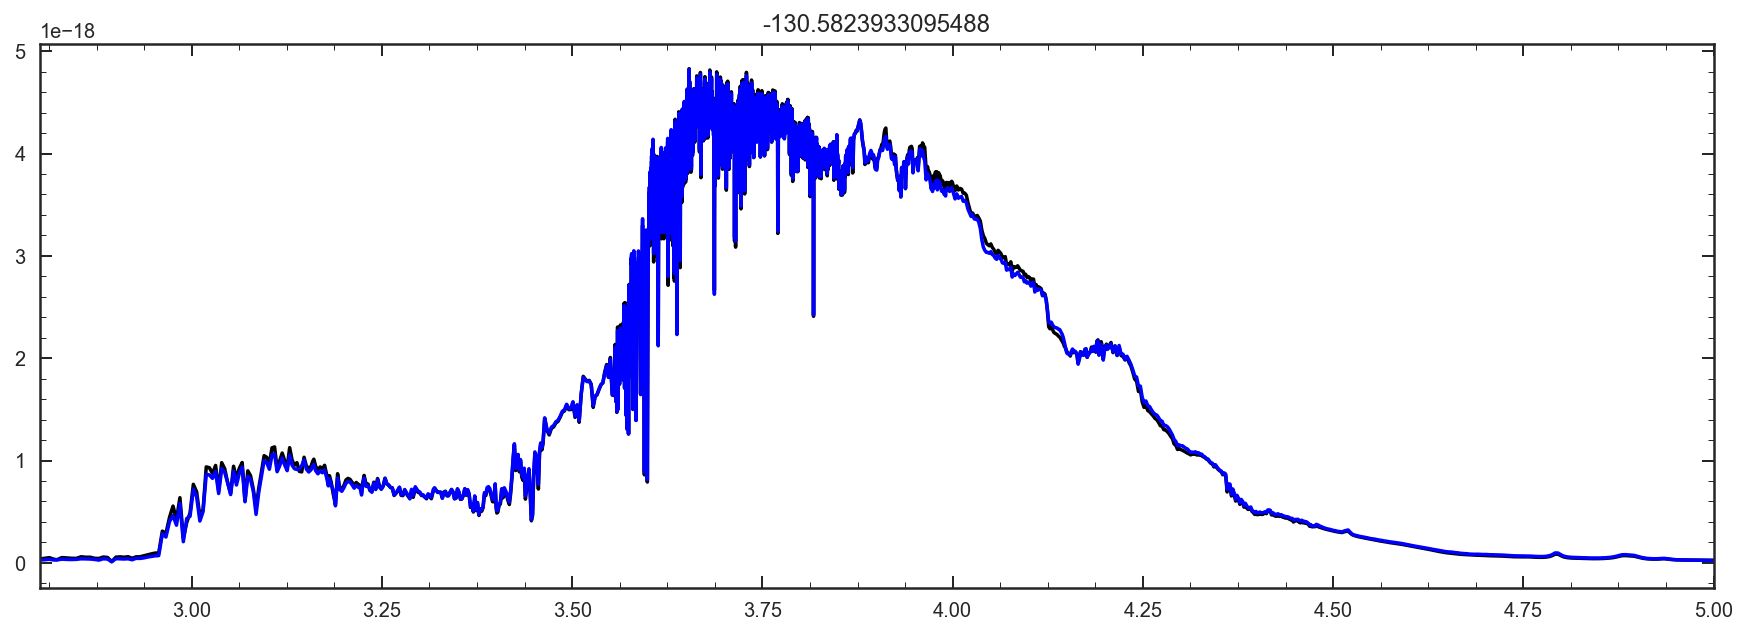

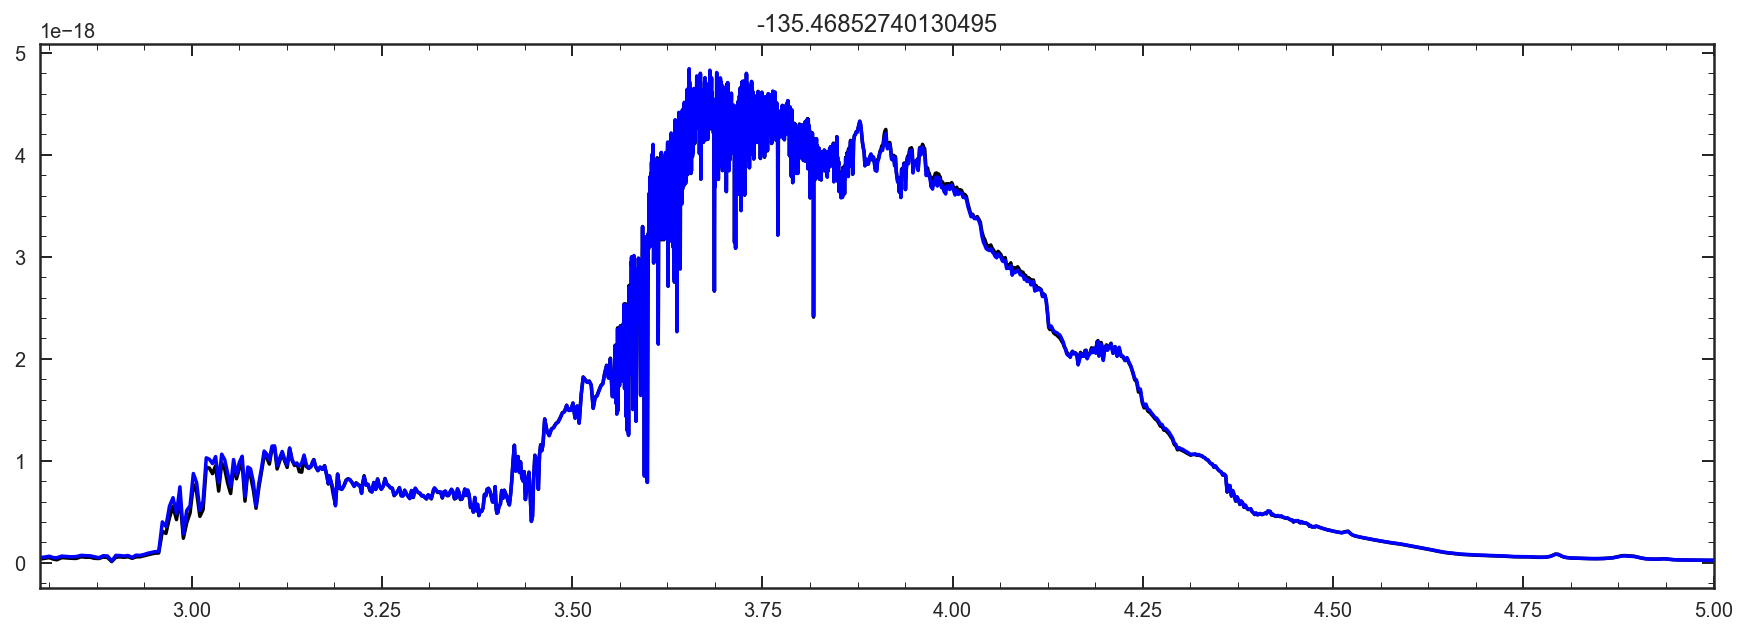

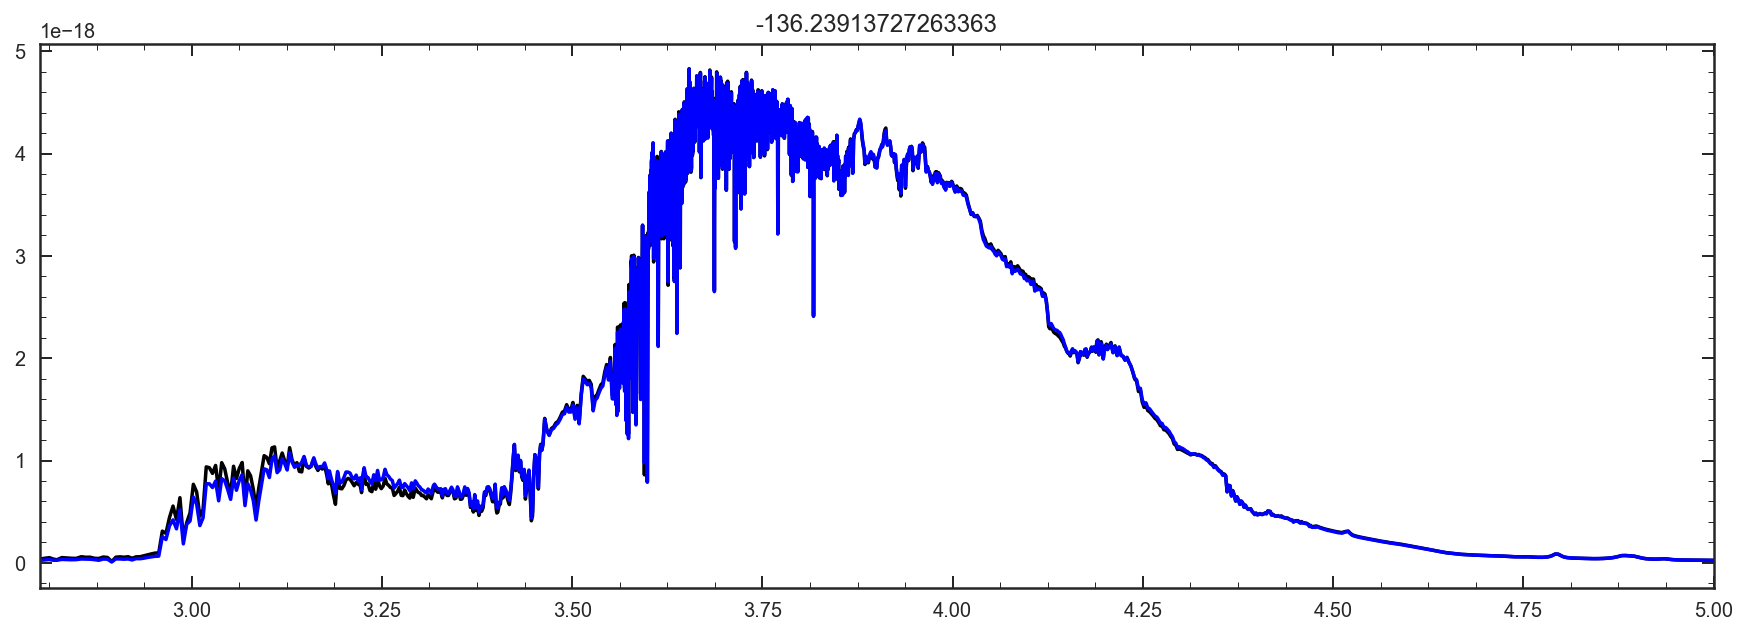

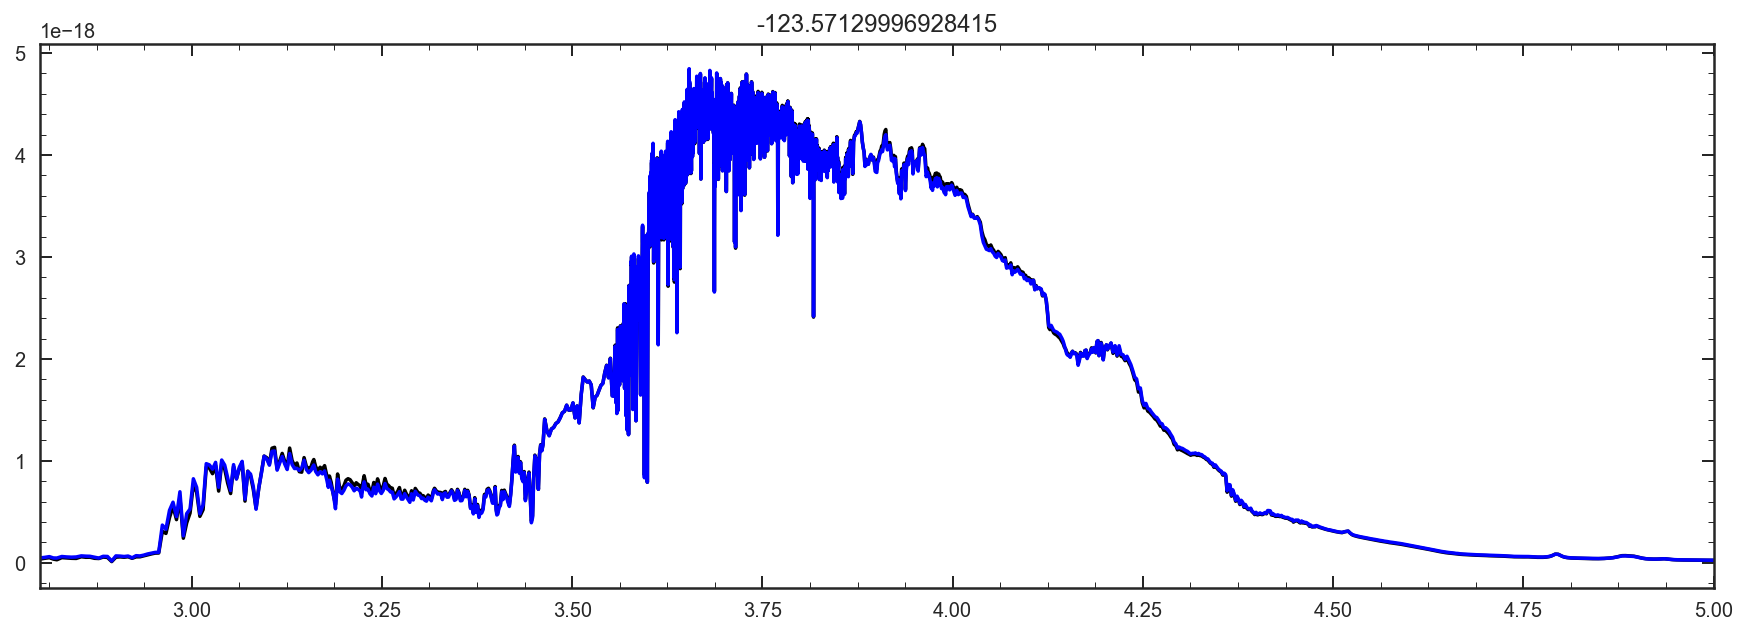

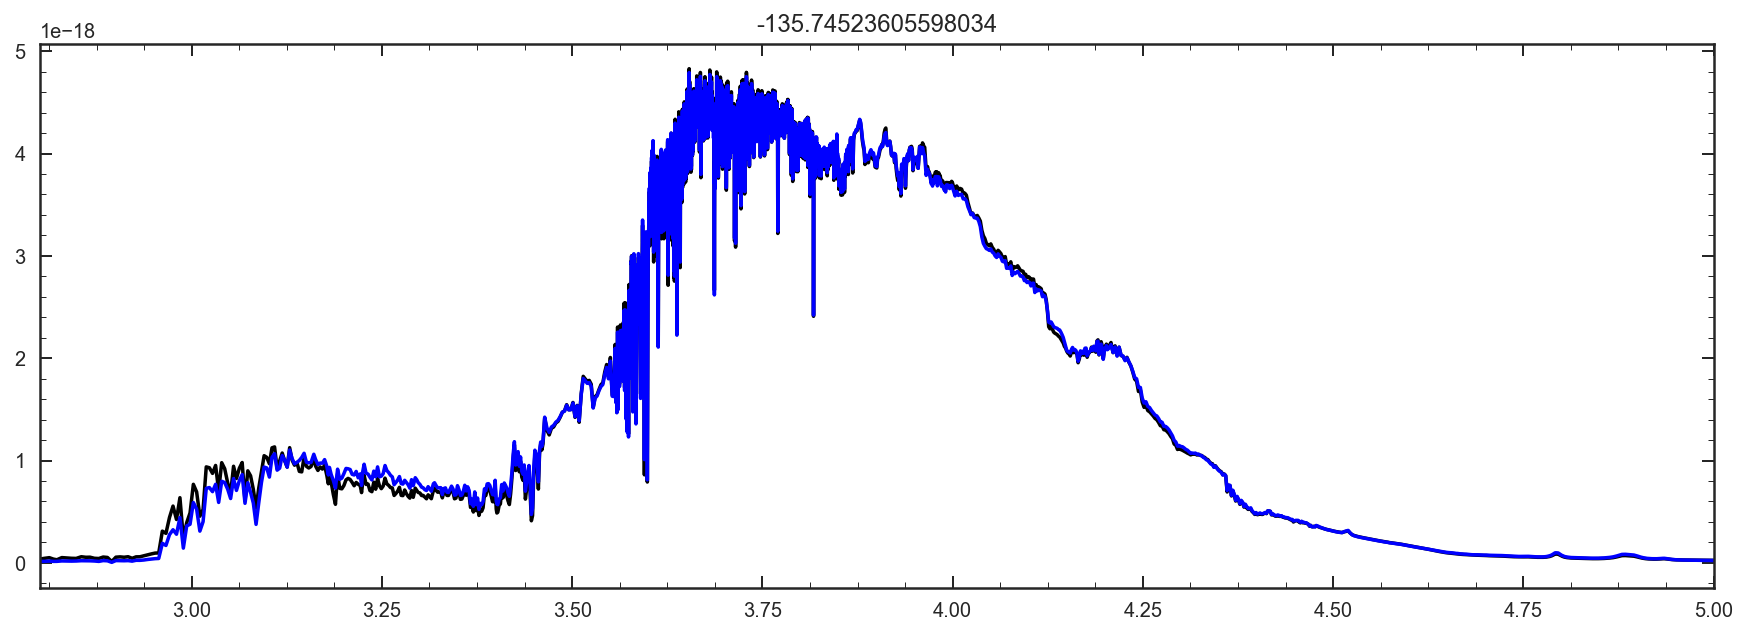

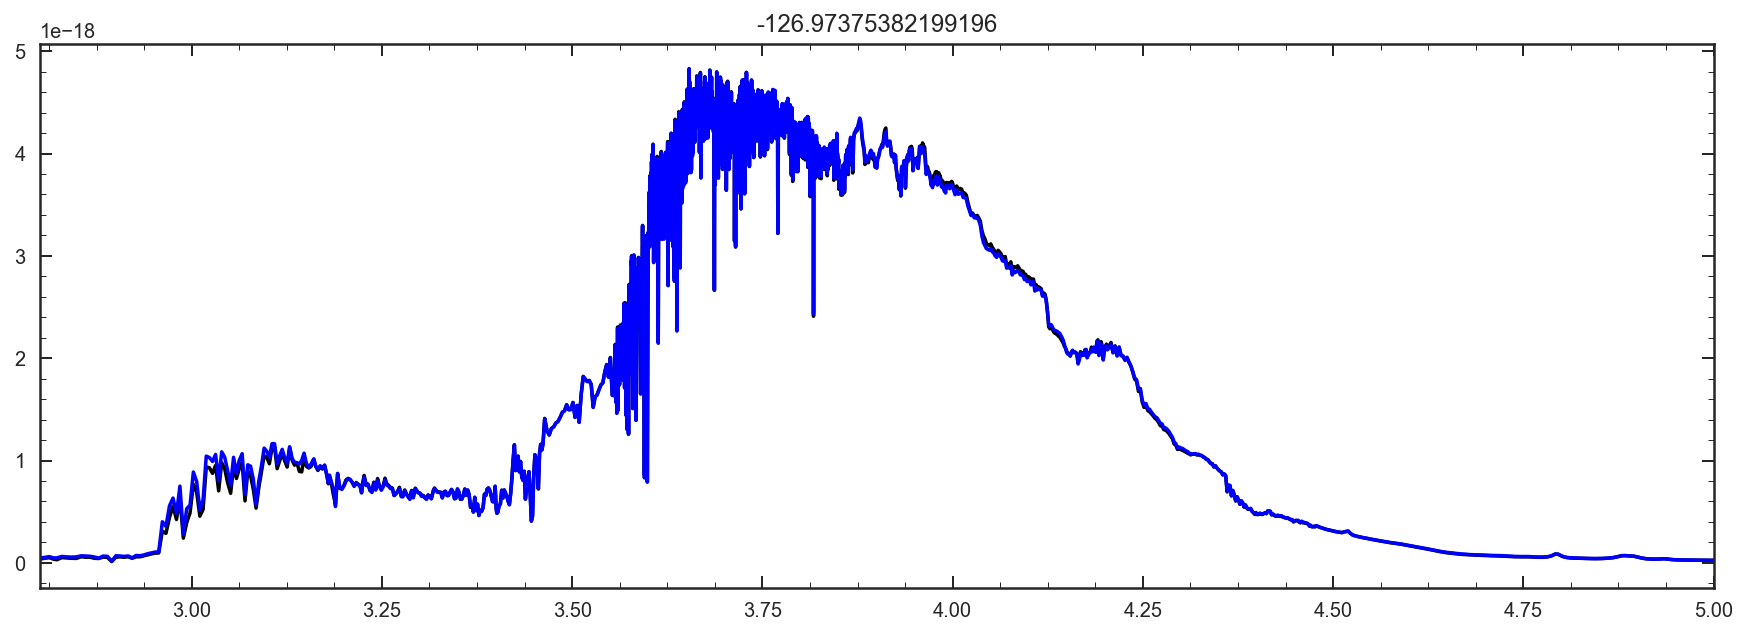

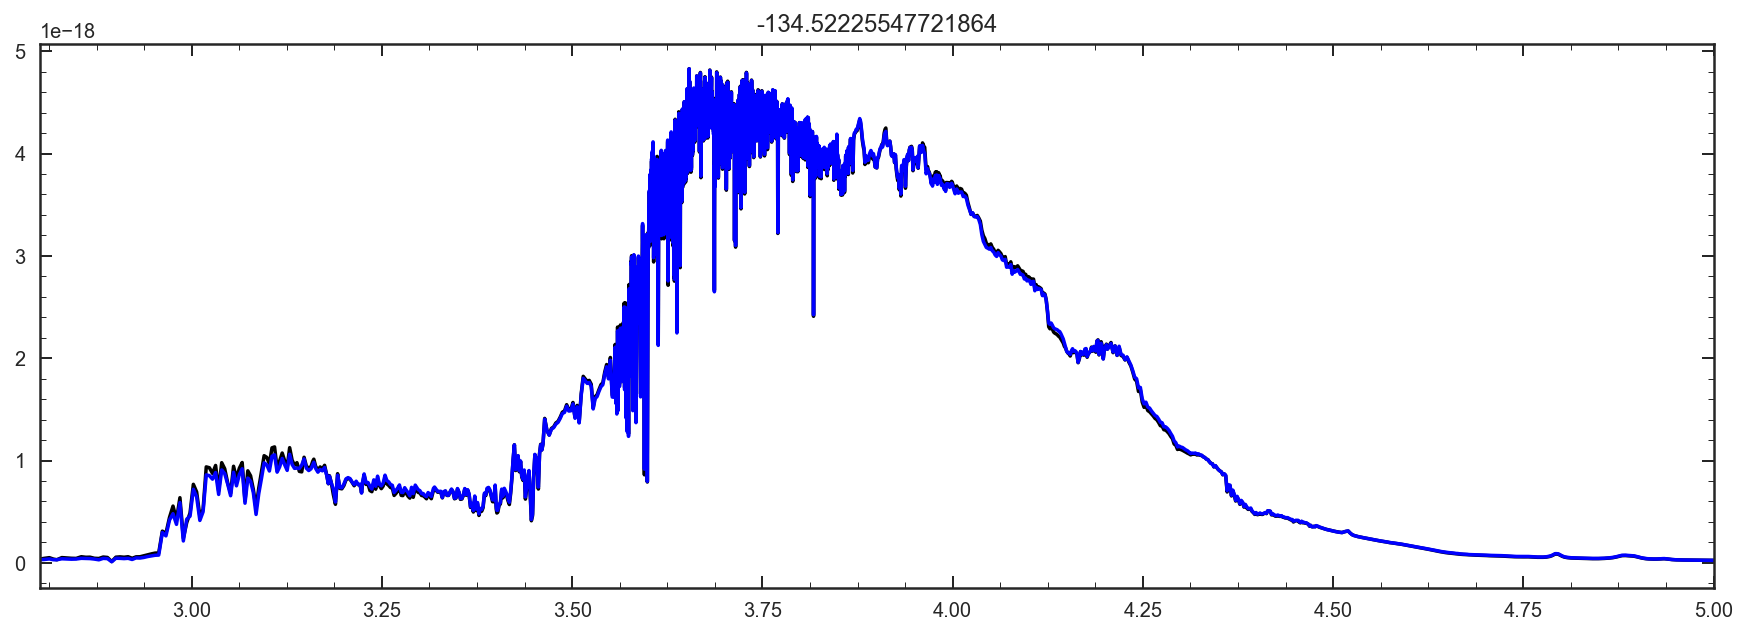

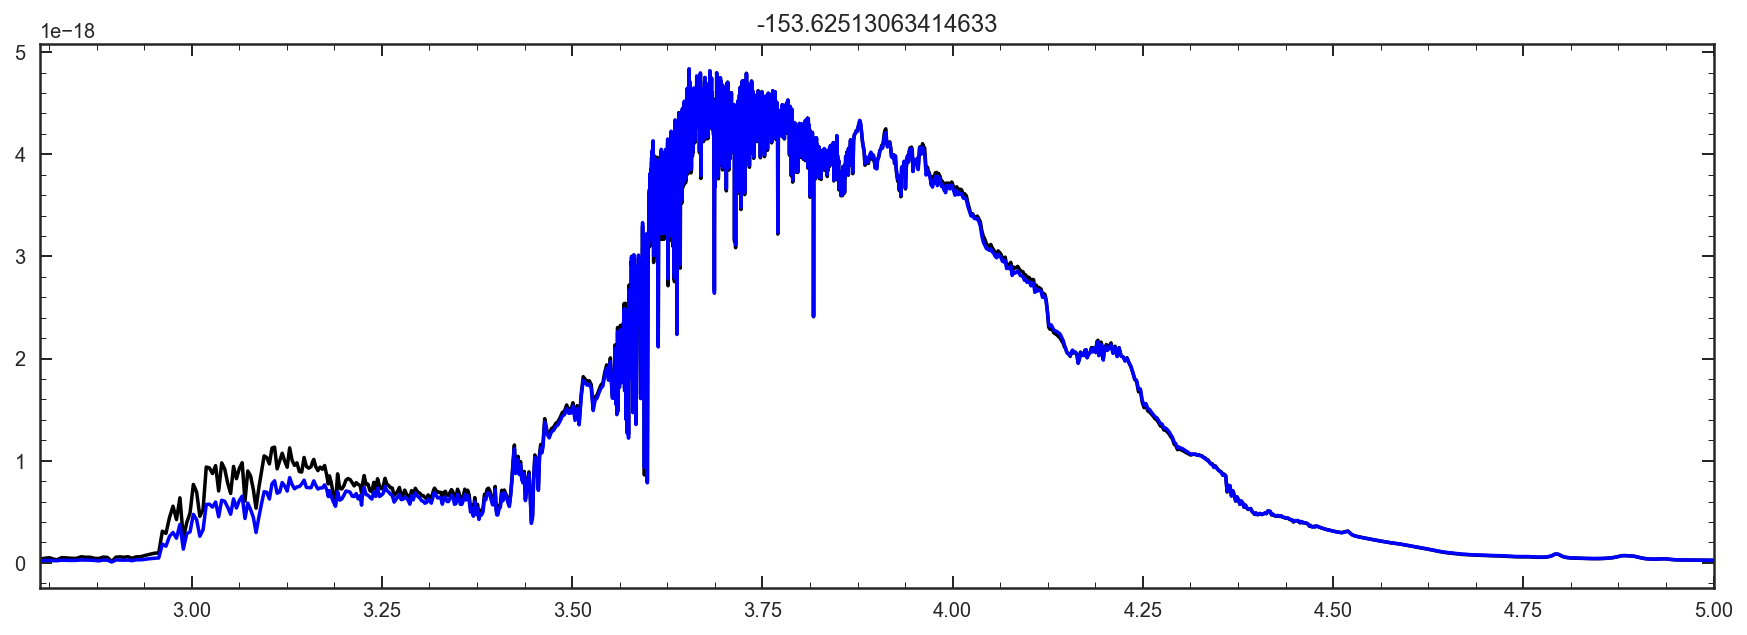

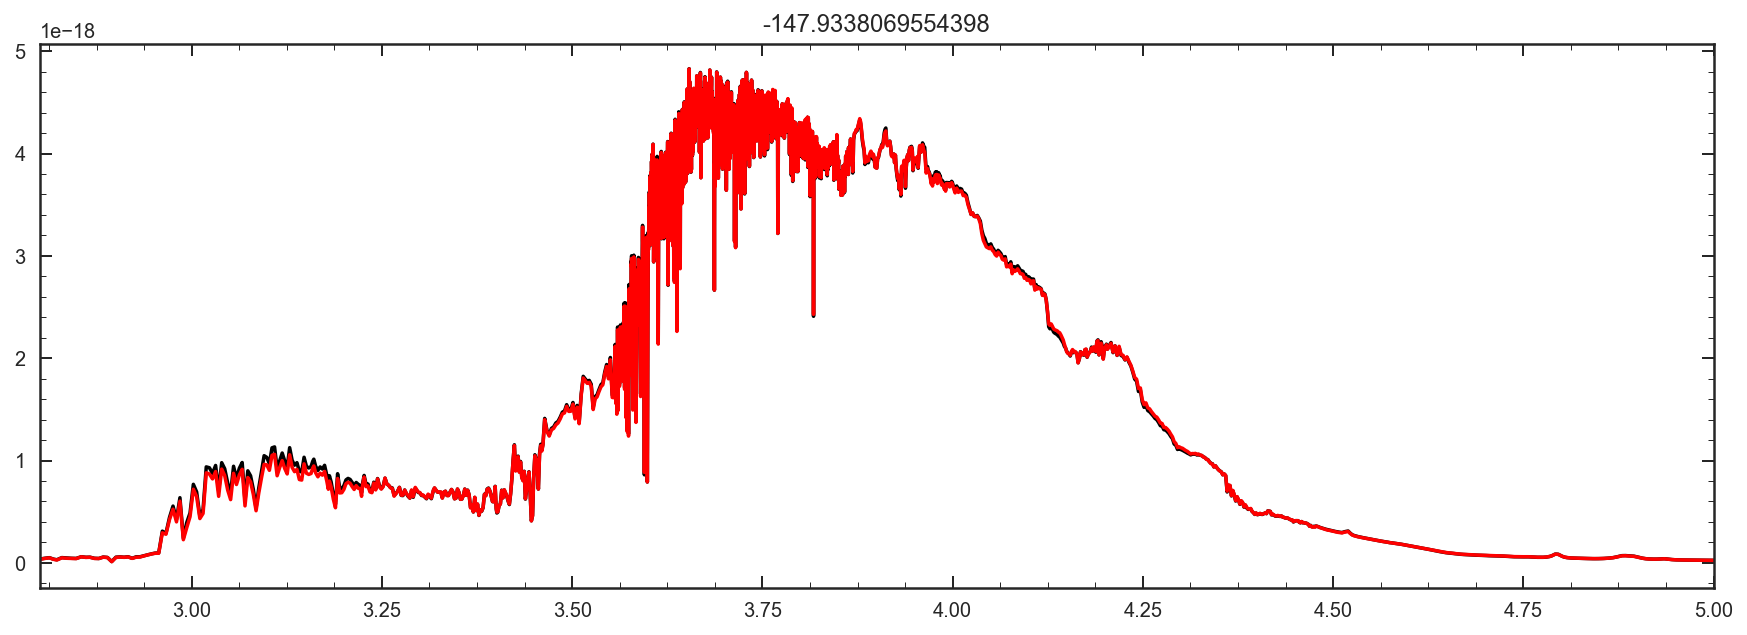

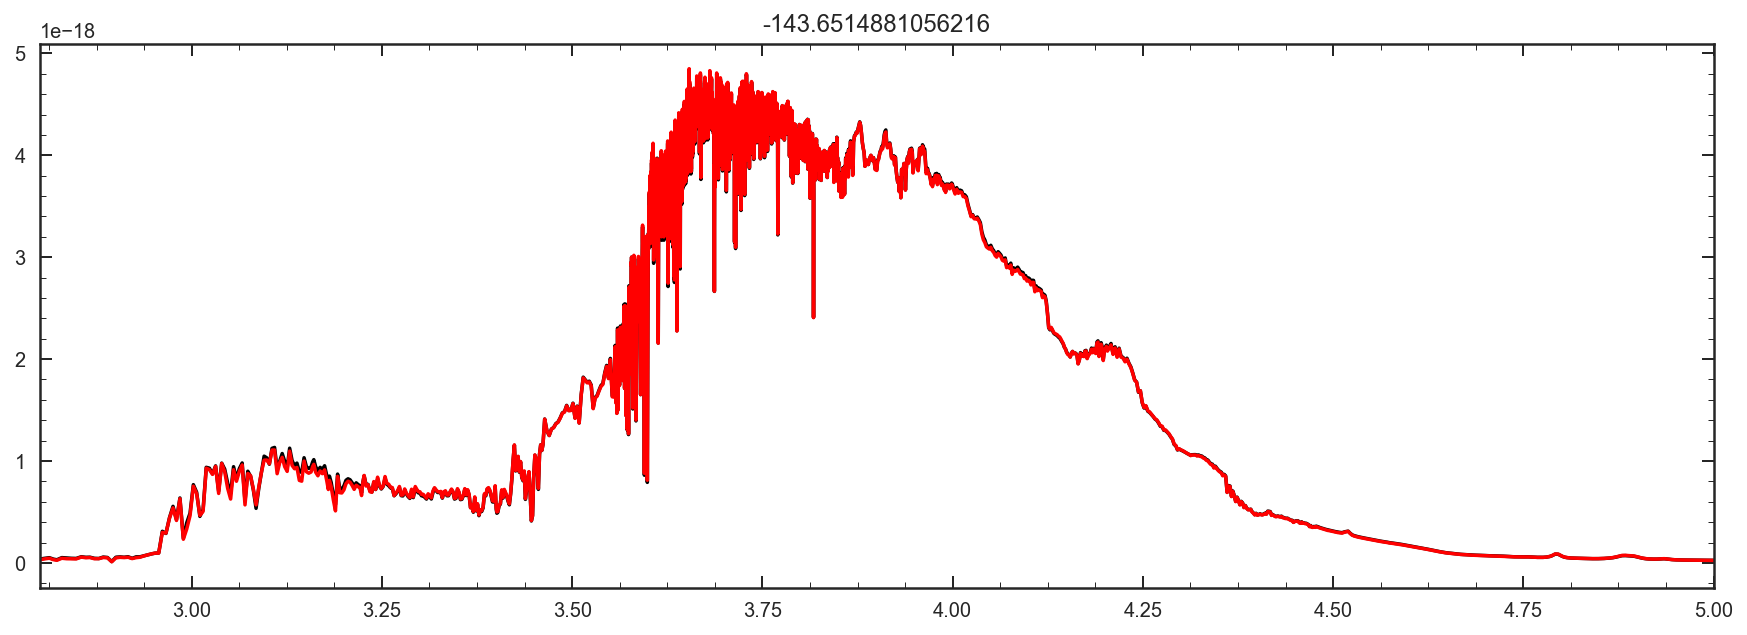

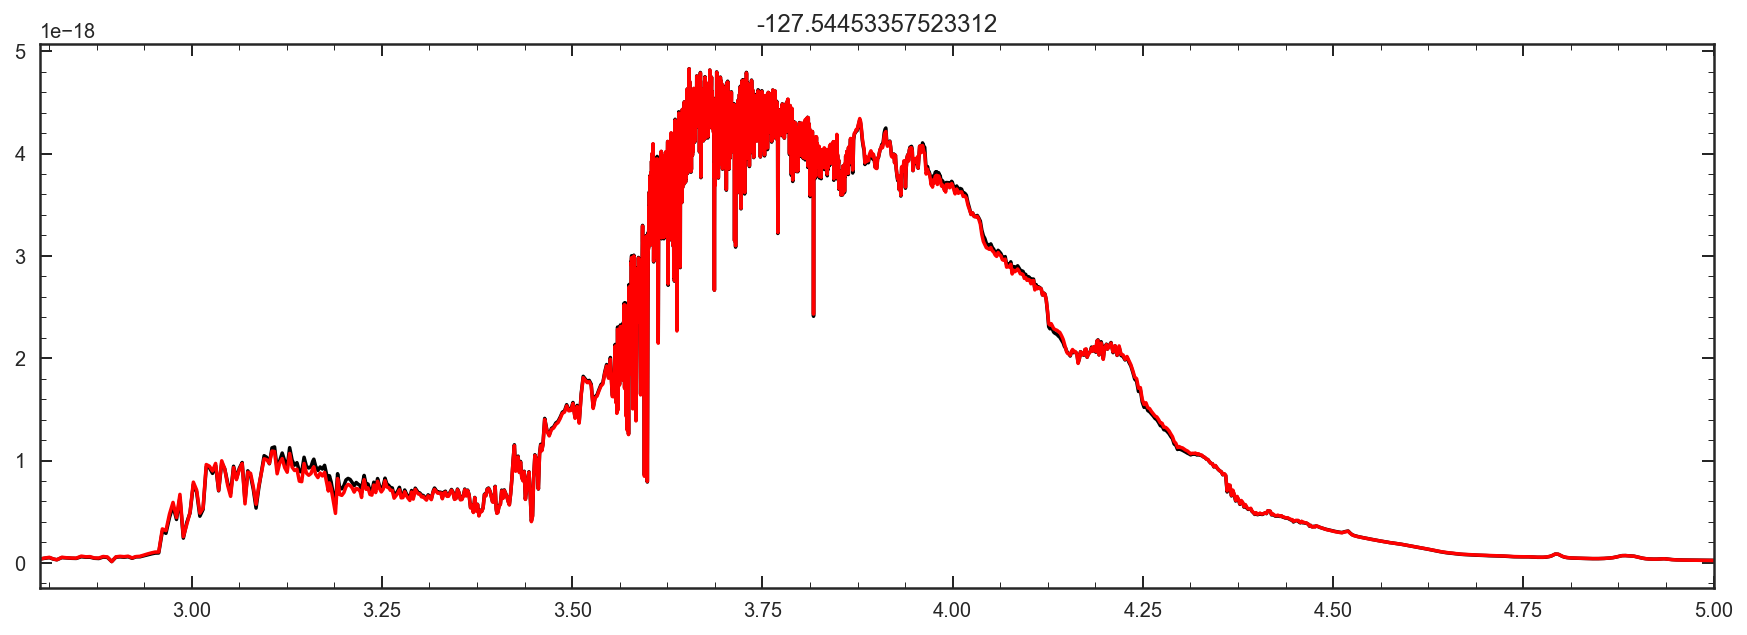

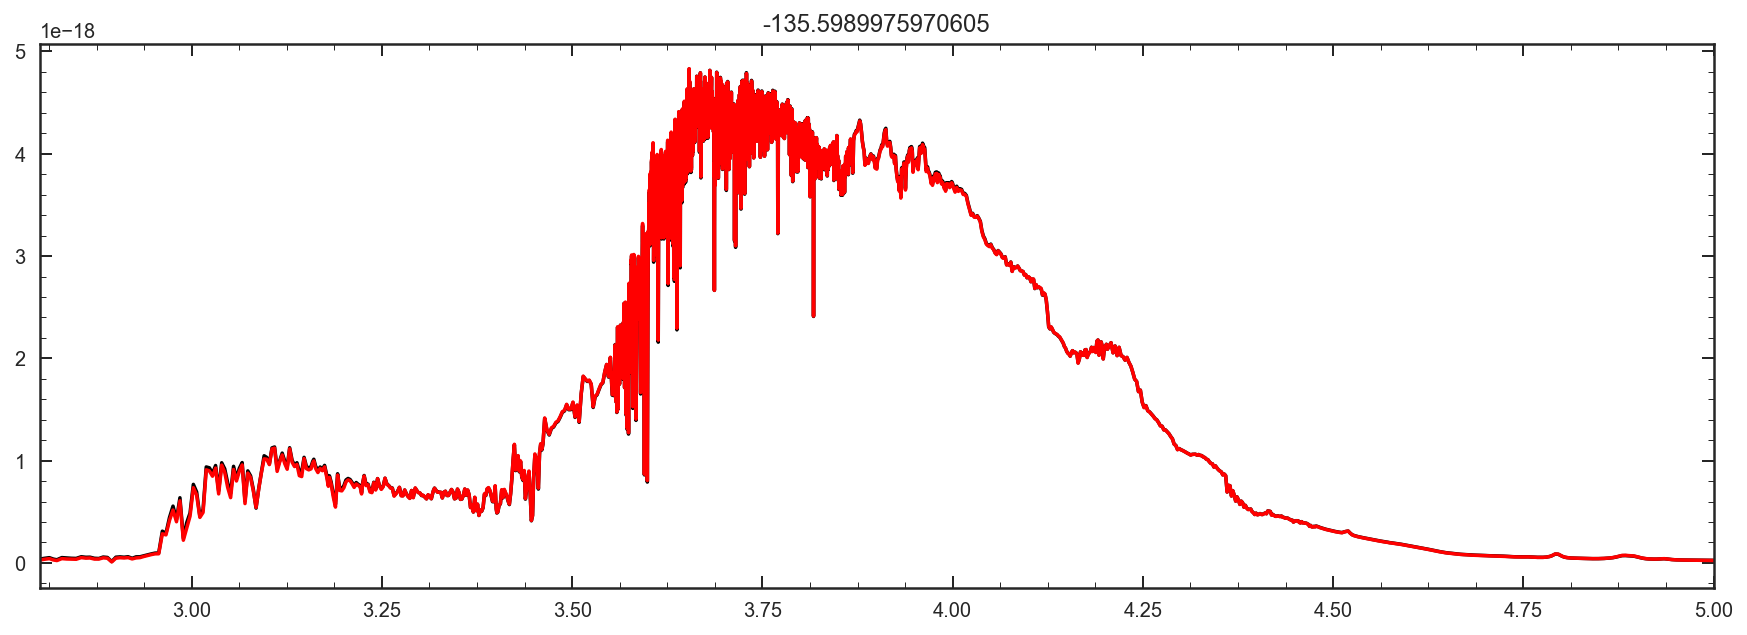

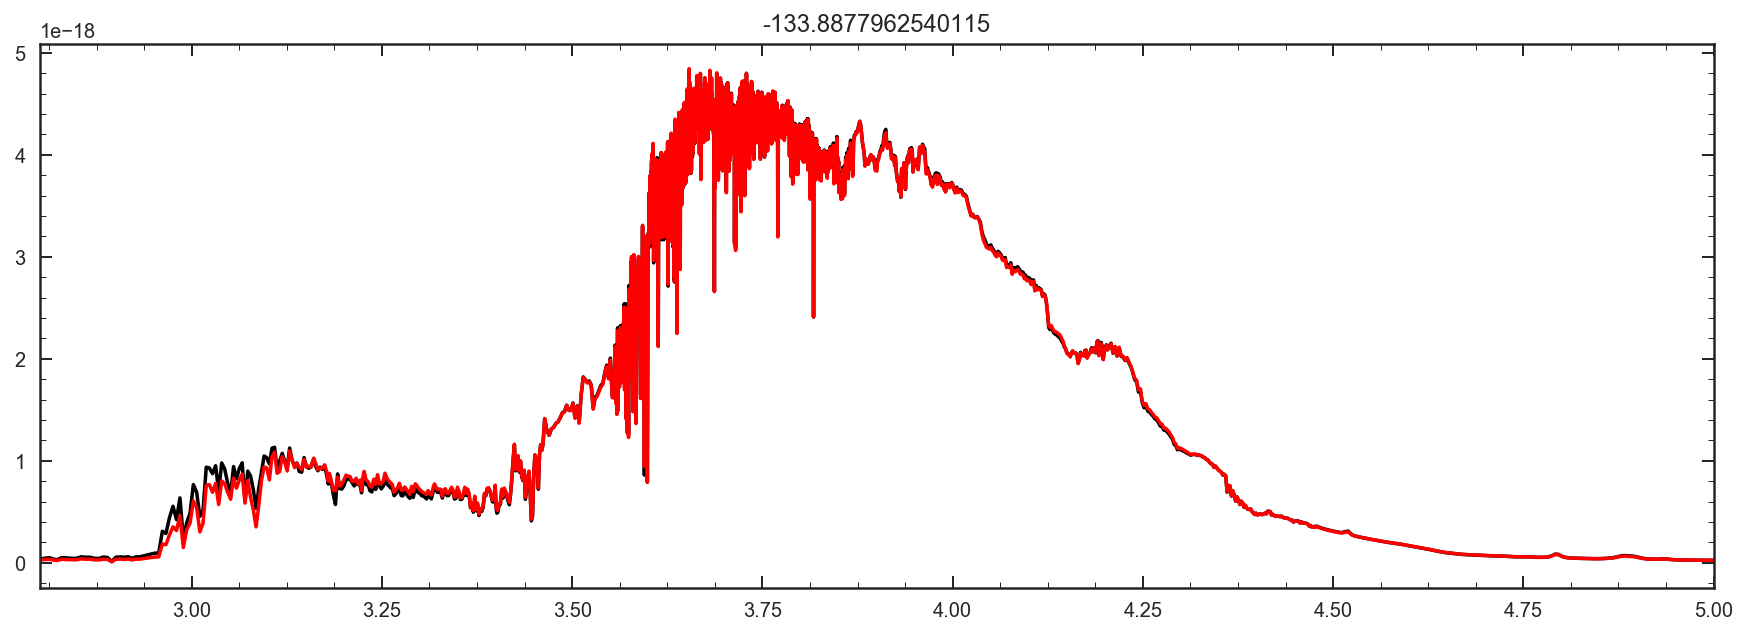

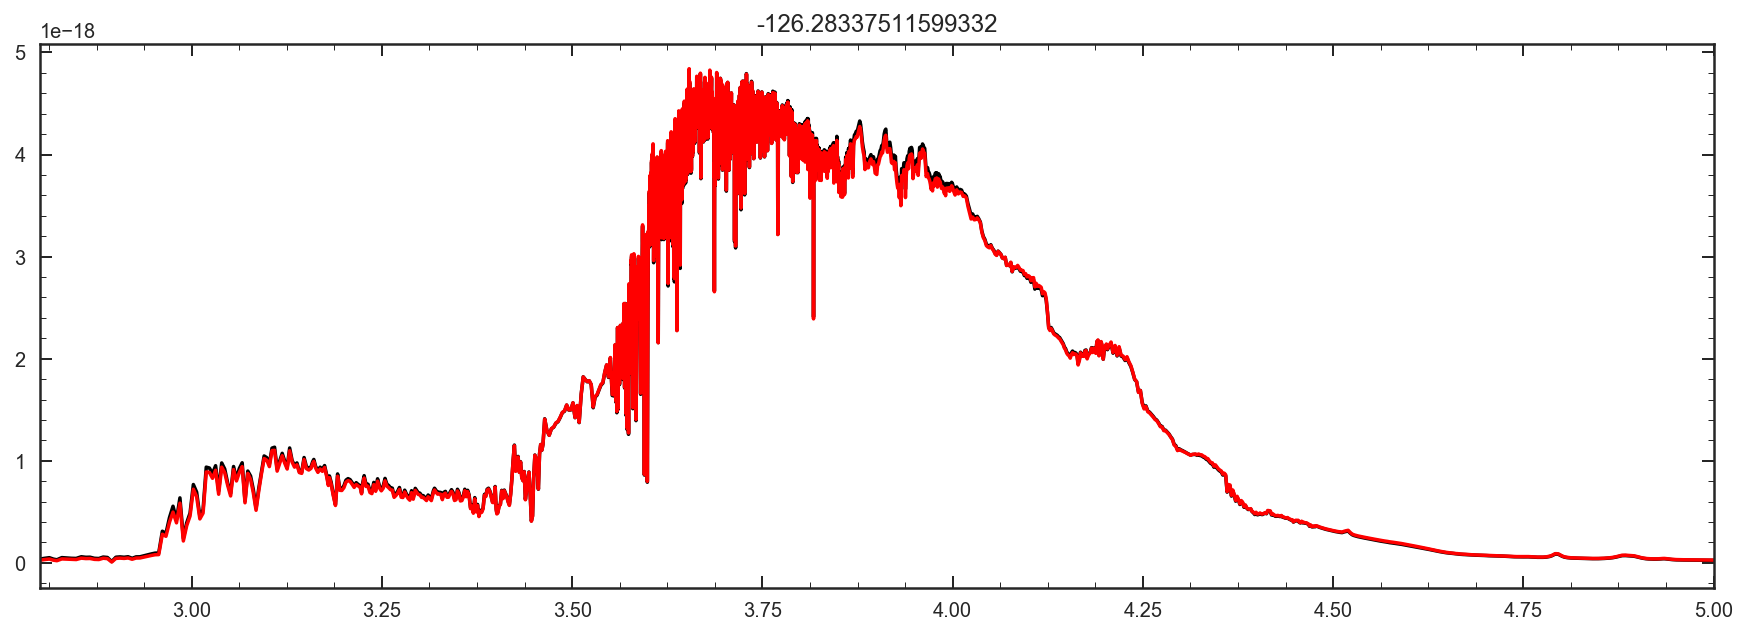

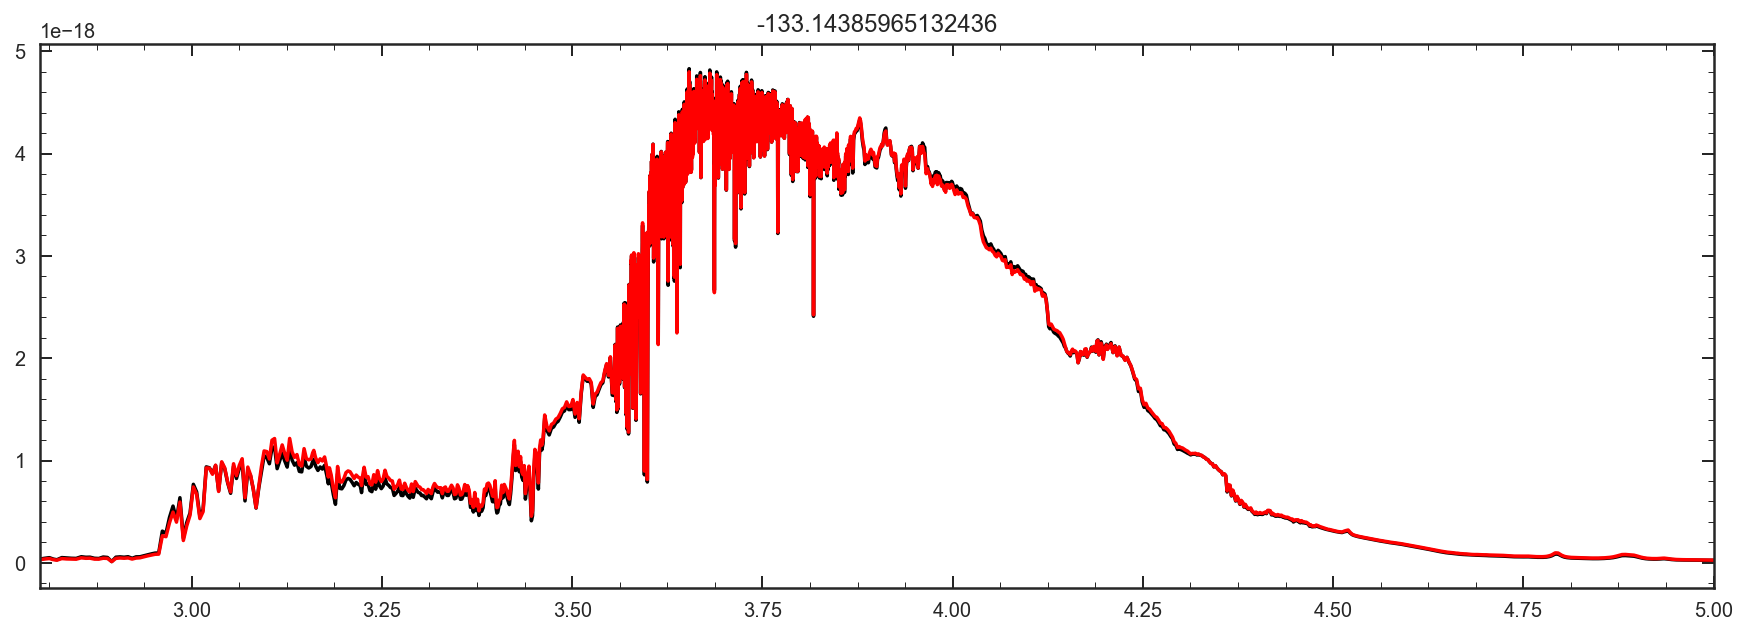

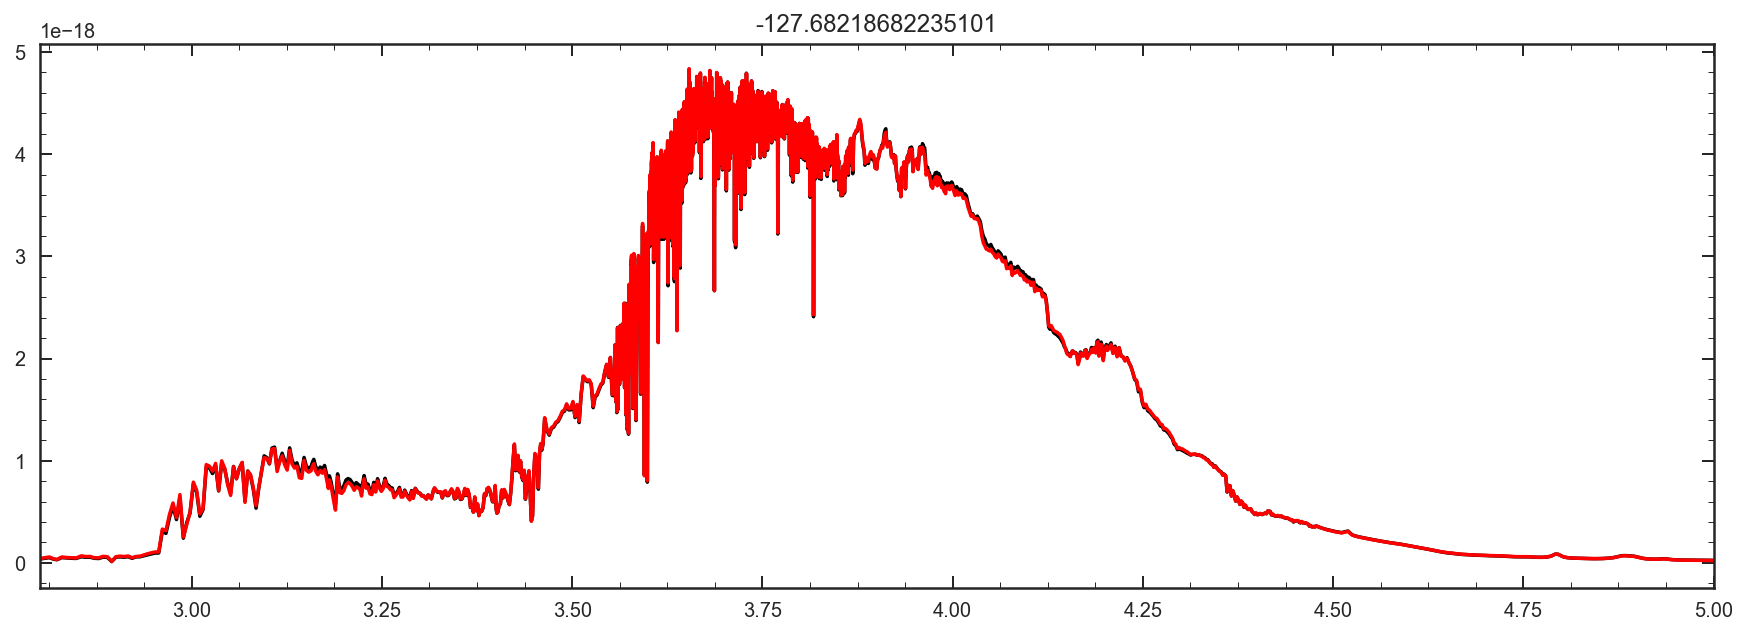

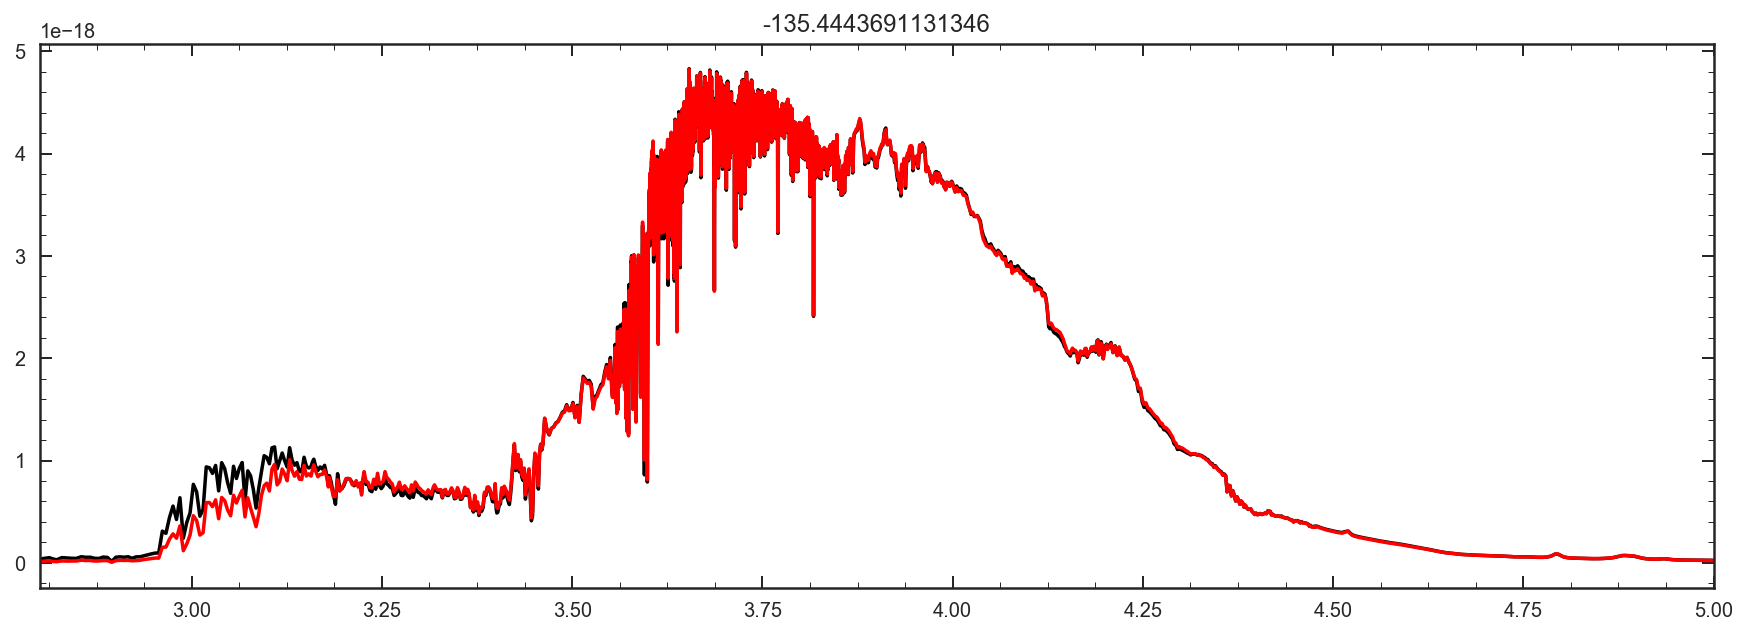

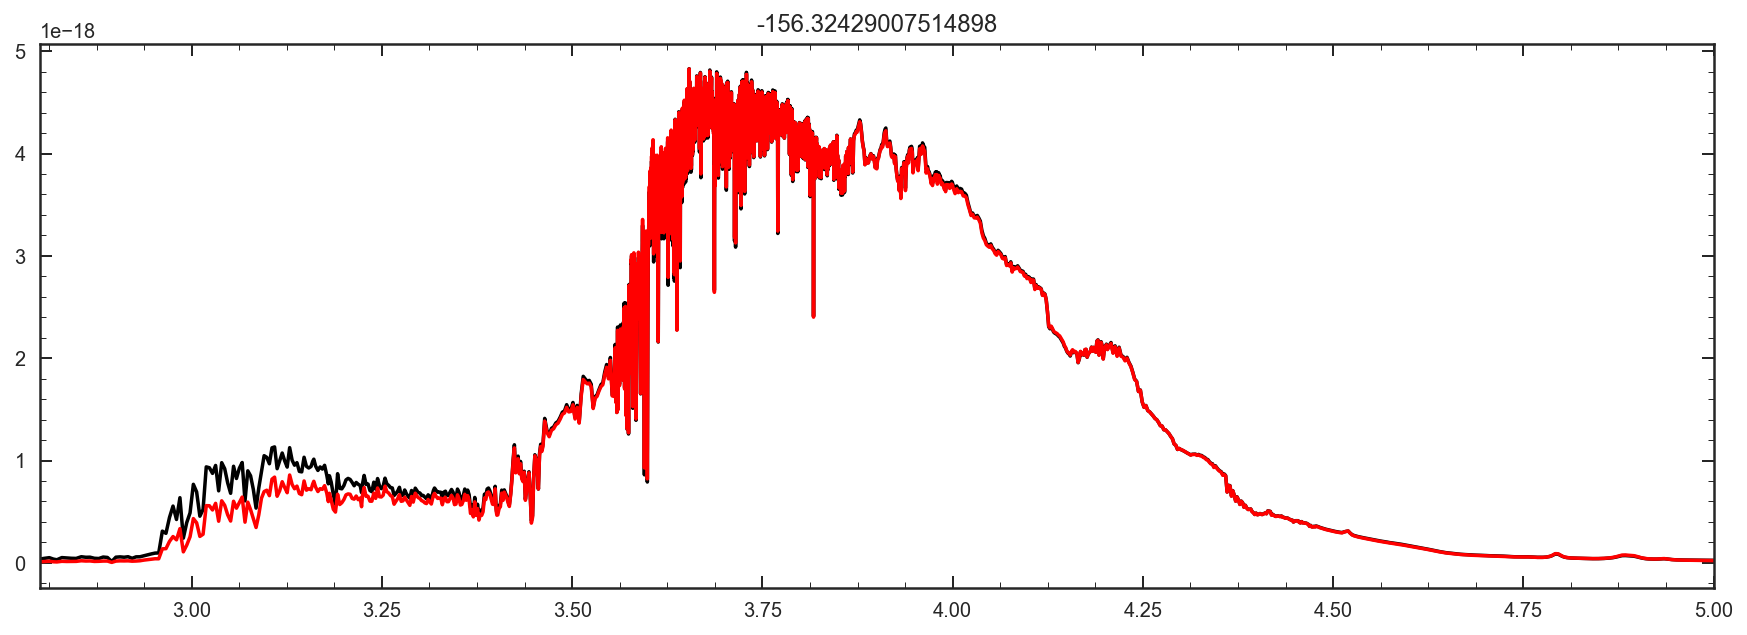

In [14]:
sp = fsps.StellarPopulation(imf_type = 2, tpagb_norm_type=0, zcontinuous = 1, logzsol = np.log10(1), sfh = 3, dust_type = 1)

for i in range(10):
#     dres = np.load(multi_list[i]).item()
    bfZ, bft, bft1, bft2, bft3, bft4, bft5, bft6, \
    bft7, bft8, bft9, bft10, bfz, bfd, bflm, logl = \
    np.load('../data/bestfits/sim_test_tab_to_tab_continuity_prior_multi_{0}_bfit.npy'.format(i+1))

    sp.params['dust2'] = bfd
    sp.params['dust1'] = bfd
    sp.params['logzsol'] = np.log10(bfZ)
    sp.set_tabular_sfh(LBT,np.array([bft1, bft2, bft3, bft4, bft5, bft6, bft7, bft8, bft9, bft10]))

    wave, flux = sp.get_spectrum(tage = bft, peraa = True)

    mp1 = sp.stellar_mass
 
    D_l = cosmo.luminosity_distance(bfz).value # in Mpc
    MT = (10**bflm / mp1) * lsol_to_fsol / (4 * np.pi * (D_l*conv)**2)

    plt.figure(figsize=[15,5])
    plt.plot(np.log10(wave1), flux1 * mass_transform,'k')
    plt.plot(np.log10(wave), flux * MT,'b')
    plt.title(logl)
    plt.xlim(2.8,5)
    
sp = fsps.StellarPopulation(imf_type = 2, tpagb_norm_type=0, zcontinuous = 3, sfh = 3, dust_type = 1)

for i in range(10):
#     dres = np.load(multi_list[i]).item()
    bfZ1,bfZ2,bfZ3,bfZ4,bfZ5,bfZ6,bfZ7,bfZ8,bfZ9,bfZ10, bft, bft1, bft2, bft3, bft4, bft5, bft6, \
    bft7, bft8, bft9, bft10, bfz, bfd, bflm, logl = \
    np.load('../data/bestfits/sim_test_tab_to_tab_continuity_prior_multi_metal_{0}_bfit.npy'.format(i+1))

    sp.params['dust2'] = bfd
    sp.params['dust1'] = bfd
    sp.params['logzsol'] = np.log10(bfZ)
    sp.set_tabular_sfh(LBT,np.array([bft1, bft2, bft3, bft4, bft5, bft6, bft7, bft8, bft9, bft10]),
                      Z = np.array([bfZ1,bfZ2,bfZ3,bfZ4,bfZ5,bfZ6,bfZ7,bfZ8,bfZ9,bfZ10])*0.019)

    wave, flux = sp.get_spectrum(tage = bft, peraa = True)

    mp1 = sp.stellar_mass
 
    D_l = cosmo.luminosity_distance(bfz).value # in Mpc
    MT = (10**bflm / mp1) * lsol_to_fsol / (4 * np.pi * (D_l*conv)**2)

    plt.figure(figsize=[15,5])
    plt.plot(np.log10(wave1), flux1 * mass_transform,'k')
    plt.plot(np.log10(wave), flux * MT,'r')
    plt.title(logl)
    plt.xlim(2.8,5)

# Compare dt spec_fits

In [37]:
sp = fsps.StellarPopulation(imf_type = 2, tpagb_norm_type=0, zcontinuous = 1, logzsol = np.log10(1), sfh = 4, tau=0.1, dust_type = 1)
sp.params['dust2'] =0.2
sp.params['dust1'] =0.2
sp.params['tau'] =0.3
sp.params['logzsol'] = np.log10(0.8)

wave2, flux2 = sp.get_spectrum(tage = 4.25, peraa = True)

mass_perc2 = sp.stellar_mass

D_l = cosmo.luminosity_distance(specz).value # in Mpc
conv = 3.086E24
lsol_to_fsol = 3.839E33

mass_transform = 10**11* lsol_to_fsol / (4 * np.pi * (D_l*conv)**2)

(2.8, 5)

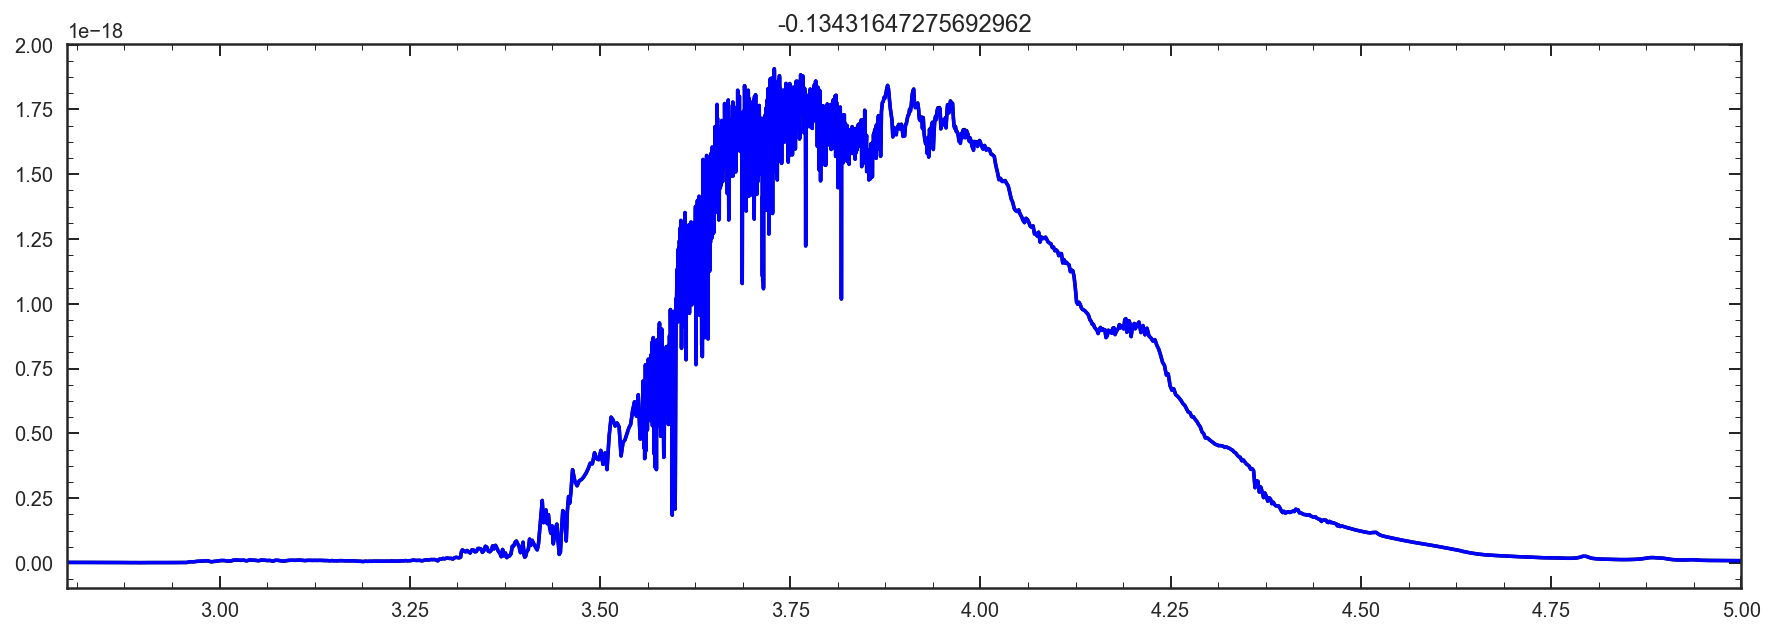

In [40]:
sp = fsps.StellarPopulation(imf_type = 2, tpagb_norm_type=0, zcontinuous = 1, logzsol = np.log10(0.8), sfh = 3, dust_type = 1)


bfZ, bft, bfm1, bfm2, bfm3, bfm4, bfm5, bfm6, \
bfm7, bfm8, bfm9, bfm10, bfz, bfd, bflm, logl = \
np.load('../data/bestfits/sim_test_delay_to_tab_1_bfit.npy')

sp.params['dust2'] = bfd
sp.params['dust1'] = bfd
sp.params['logzsol'] = np.log10(bfZ)

time, sfr, tmax = convert_sfh(agebins,[bfm1, bfm2,bfm3, bfm4, bfm5, bfm6,bfm7, bfm8, bfm9, bfm10])

sp.set_tabular_sfh(time,sfr)

wave, flux = sp.get_spectrum(tage = bft, peraa = True)

mp1 = sp.stellar_mass

D_l = cosmo.luminosity_distance(bfz).value # in Mpc
MT = (10**bflm / mp1) * lsol_to_fsol / (4 * np.pi * (D_l*conv)**2)

plt.figure(figsize=[15,5])
plt.plot(np.log10(wave2), flux2 * mass_transform,'k')
plt.plot(np.log10(wave), flux * MT,'b')
plt.title(logl)
plt.xlim(2.8,5)

In [21]:
sp = fsps.StellarPopulation(imf_type = 2, tpagb_norm_type=0, zcontinuous = 1, logzsol = np.log10(1), sfh = 3, dust_type = 1)

for i in range(10):
    dres = np.load(multi_list[i]).item()
    bfZ, bft, bft1, bft2, bft3, bft4, bft5, bft6, \
    bft7, bft8, bft9, bft10, bfz, bfd, bflm, logl = \
    np.load('../data/bestfits/sim_test_delay_to_tab_continuity_prior_multi_{0}_bfit.npy'.format(i+1))

    sp.params['dust2'] = bfd
    sp.params['dust1'] = bfd
    sp.params['logzsol'] = np.log10(bfZ)
    sp.set_tabular_sfh(LBT,np.array([bft1, bft2, bft3, bft4, bft5, bft6, bft7, bft8, bft9, bft10]))

    wave, flux = sp.get_spectrum(tage = bft, peraa = True)

    mp1 = sp.stellar_mass
 
    D_l = cosmo.luminosity_distance(bfz).value # in Mpc
    MT = (10**bflm / mp1) * lsol_to_fsol / (4 * np.pi * (D_l*conv)**2)

    plt.figure(figsize=[15,5])
    plt.plot(np.log10(wave2), flux2 * mass_transform,'k')
    plt.plot(np.log10(wave), flux * MT,'b')
    plt.title(dres.logl[-1])
    plt.xlim(2.8,5)
    
sp = fsps.StellarPopulation(imf_type = 2, tpagb_norm_type=0, zcontinuous = 3, sfh = 3, dust_type = 1)

for i in range(10):
    dres = np.load(multi_list[i]).item()
    bfZ1,bfZ2,bfZ3,bfZ4,bfZ5,bfZ6,bfZ7,bfZ8,bfZ9,bfZ10, bft, bft1, bft2, bft3, bft4, bft5, bft6, \
    bft7, bft8, bft9, bft10, bfz, bfd, bflm, logl = \
    np.load('../data/bestfits/sim_test_delay_to_tab_continuity_prior_multi_metal_{0}_bfit.npy'.format(i+1))

    sp.params['dust2'] = bfd
    sp.params['dust1'] = bfd
    sp.params['logzsol'] = np.log10(bfZ)
    sp.set_tabular_sfh(LBT,np.array([bft1, bft2, bft3, bft4, bft5, bft6, bft7, bft8, bft9, bft10]),
                      Z = np.array([bfZ1,bfZ2,bfZ3,bfZ4,bfZ5,bfZ6,bfZ7,bfZ8,bfZ9,bfZ10])*0.019)

    wave, flux = sp.get_spectrum(tage = bft, peraa = True)

    mp1 = sp.stellar_mass
 
    D_l = cosmo.luminosity_distance(bfz).value # in Mpc
    MT = (10**bflm / mp1) * lsol_to_fsol / (4 * np.pi * (D_l*conv)**2)

    plt.figure(figsize=[15,5])
    plt.plot(np.log10(wave2), flux2 * mass_transform,'k')
    plt.plot(np.log10(wave), flux * MT,'r')
    plt.title(dres.logl[-1])
    plt.xlim(2.8,5)

NameError: name 'lsol_to_fsol' is not defined

# Compare td SFHs

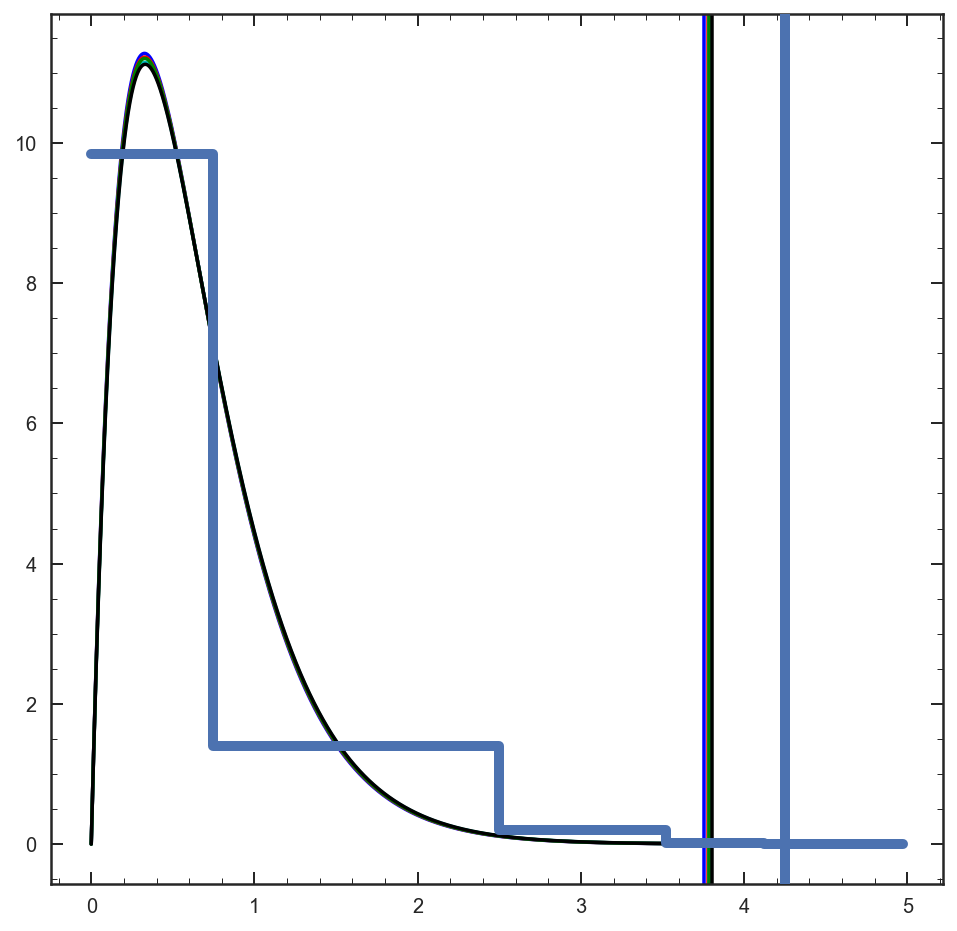

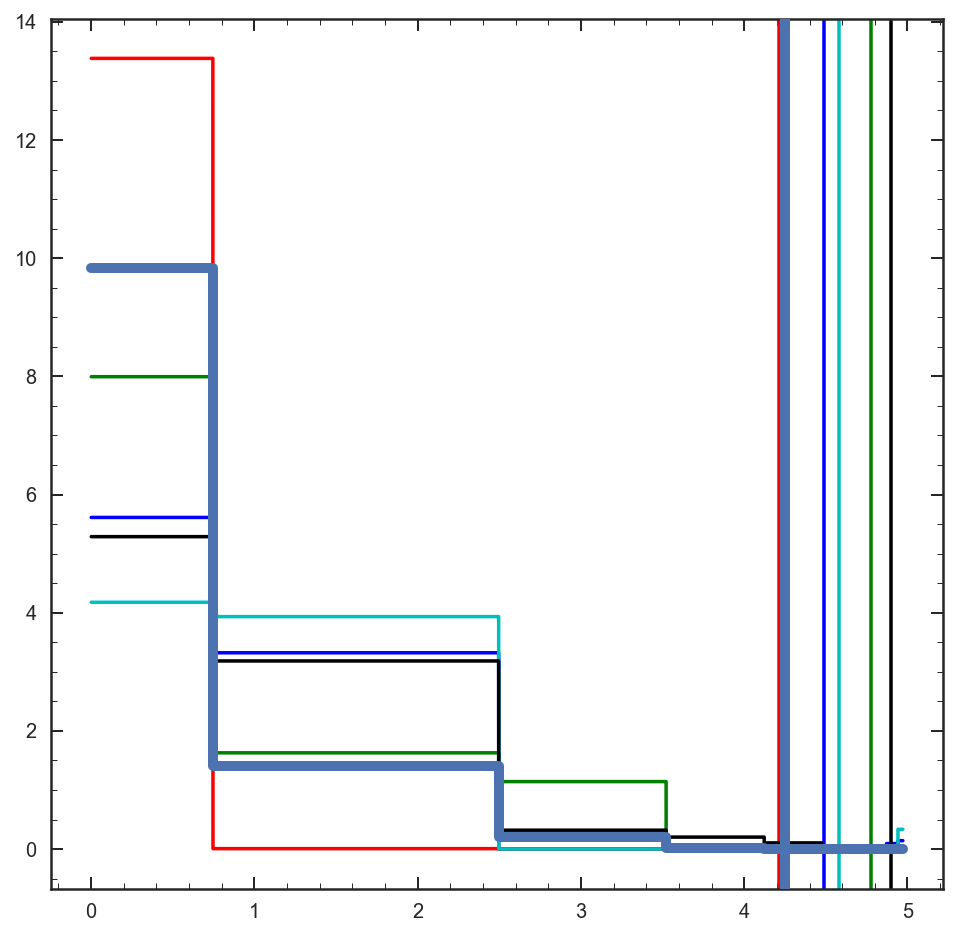

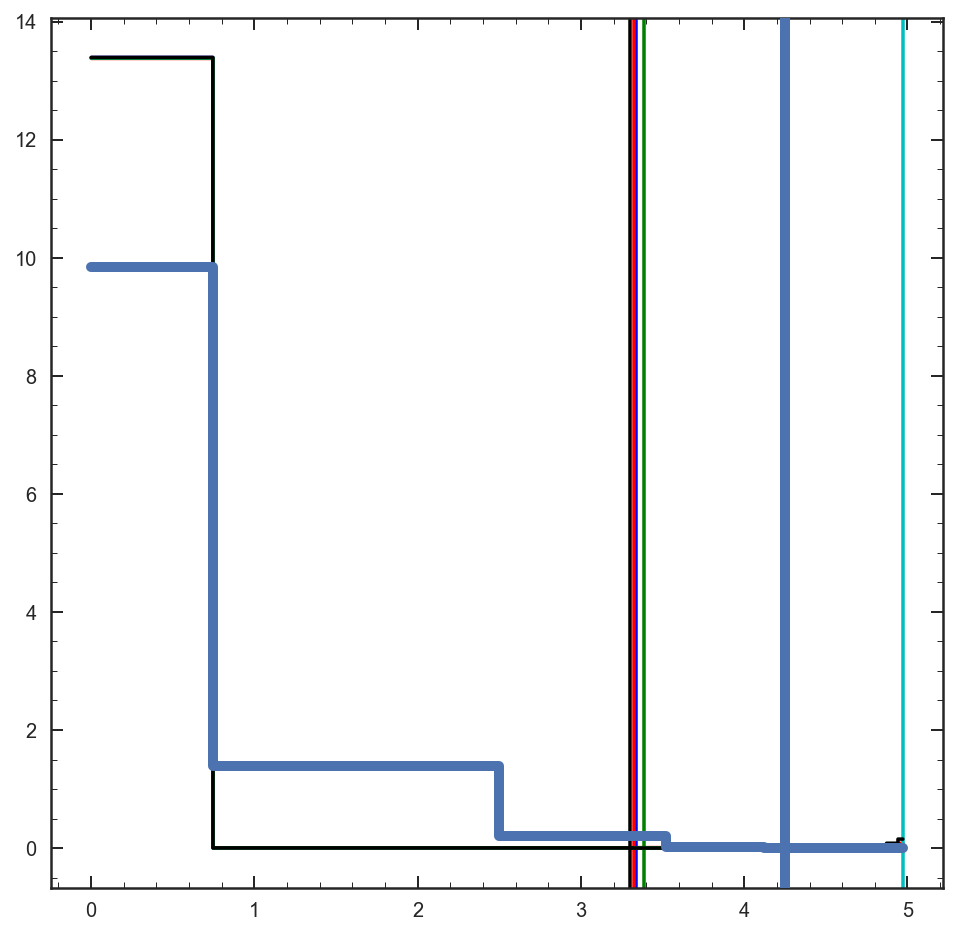

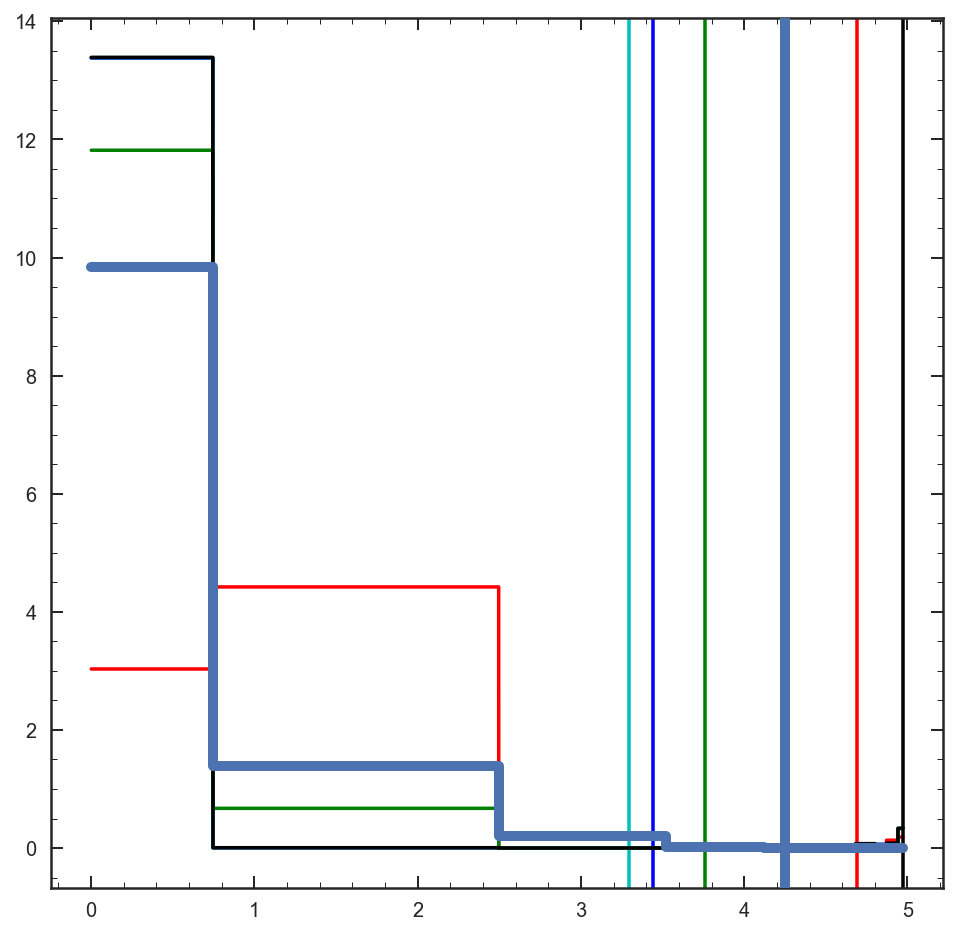

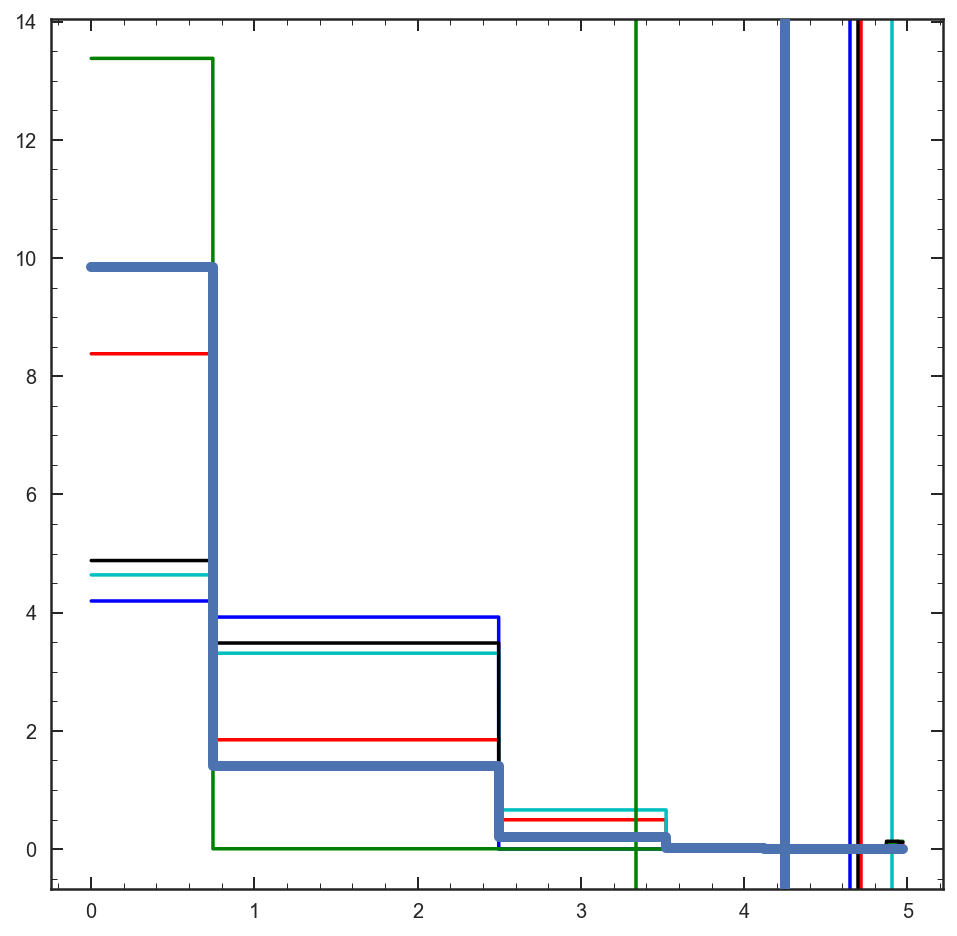

In [69]:
tab_masses = np.array([0.00, 0.00, 0.000, 0.0000, 0.0001, 0.0001, 0.001, 0.025, 0.3, 0.9])
time, sfr, tmax = convert_sfh(agebins, tab_masses)
sc_sfr = scale_sfr(sfr, time,1)

colors = ['b','r','c','g','k']

T= np.arange(0,Oldest_galaxy(1.25)+.001,.001)

plt.figure(figsize=[8,8])
plt.step(time, sc_sfr, zorder=9, linewidth = 5)
plt.axvline(4.25, zorder=9, linewidth = 5)
for i in range(5):
    t,pt = np.load('../data/posteriors/sim_test_tab_to_delay_multi_{0}_Pt.npy'.format(i + 1))
    a,pa = np.load('../data/posteriors/sim_test_tab_to_delay_multi_{0}_Pa.npy'.format(i + 1))
    
    tau = t[pt == max(pt)][0]
    age = a[pa == max(pa)][0]
    
    sfh = T * np.exp(-T / tau)
    sc_sfh = scale_sfr(sfh, T, 1)
    plt.plot(T,sc_sfh, color = colors[i])
    plt.axvline(age, color = colors[i])
    
plt.figure(figsize=[8,8])
plt.step(time, sc_sfr, zorder=9, linewidth = 5)
plt.axvline(4.25, zorder=9, linewidth = 5)
for i in range(5):
    md = np.zeros(10)

    for ii in range(10):
        t,pt = np.load('../data/posteriors/sim_test_tab_to_tab_{0}_Pm{1}.npy'.format(i+1,ii+1))
        md[ii] = t[pt == max(pt)]
    TIME, SFR, tmax = convert_sfh(agebins, md)
    sc_SFR = scale_sfr(SFR, TIME,1)
    a,pa = np.load('../data/posteriors/sim_test_tab_to_tab_{0}_Pa.npy'.format(i+1))
    age = a[pa == max(pa)][0]
    
    plt.plot(TIME, sc_SFR, color = colors[i])
    plt.axvline(age, color = colors[i])

plt.figure(figsize=[8,8])
plt.step(time, sc_sfr, zorder=9, linewidth = 5)
plt.axvline(4.25, zorder=9, linewidth = 5)
for i in range(5):
    md = np.zeros(7)

    for ii in range(7):
        t,pt = np.load('../data/posteriors/sim_test_tab_to_tab_lessbin_{0}_Pm{1}.npy'.format(i+1,ii+1))
        md[ii] = t[pt == max(pt)]
    TIME, SFR, tmax = convert_sfh(agebins2, md)
    sc_SFR = scale_sfr(SFR, TIME,1)
    a,pa = np.load('../data/posteriors/sim_test_tab_to_tab_lessbin_{0}_Pa.npy'.format(i+1))
    age = a[pa == max(pa)][0]
    
    plt.plot(TIME, sc_SFR, color = colors[i])
    plt.axvline(age, color = colors[i])
    
plt.figure(figsize=[8,8])
plt.step(time, sc_sfr, zorder=9, linewidth = 5)
plt.axvline(4.25, zorder=9, linewidth = 5)
for i in range(5):
    md = np.zeros(10)

    for ii in range(10):
        t,pt = np.load('../data/posteriors/sim_test_tab_to_tab_sclmass_{0}_Pm{1}.npy'.format(i+1,ii+1))
        md[ii] = t[pt == max(pt)]
    TIME, SFR, tmax = convert_sfh(agebins, md)
    sc_SFR = scale_sfr(SFR, TIME,1)
    a,pa = np.load('../data/posteriors/sim_test_tab_to_tab_sclmass_{0}_Pa.npy'.format(i+1))
    age = a[pa == max(pa)][0]
    
    plt.plot(TIME, sc_SFR, color = colors[i])
    plt.axvline(age, color = colors[i])
    
plt.figure(figsize=[8,8])
plt.step(time, sc_sfr, zorder=9, linewidth = 5)
plt.axvline(4.25, zorder=9, linewidth = 5)
for i in range(5):
    md = np.zeros(10)

    for ii in range(10):
        t,pt = np.load('../data/posteriors/sim_test_tab_to_tab_sclspec_{0}_Pm{1}.npy'.format(i+1,ii+1))
        md[ii] = t[pt == max(pt)]
    TIME, SFR, tmax = convert_sfh(agebins, md)
    sc_SFR = scale_sfr(SFR, TIME,1)
    a,pa = np.load('../data/posteriors/sim_test_tab_to_tab_sclspec_{0}_Pa.npy'.format(i+1))
    age = a[pa == max(pa)][0]
    
    plt.plot(TIME, sc_SFR, color = colors[i])
    plt.axvline(age, color = colors[i])
    

# Compare dt SFHs

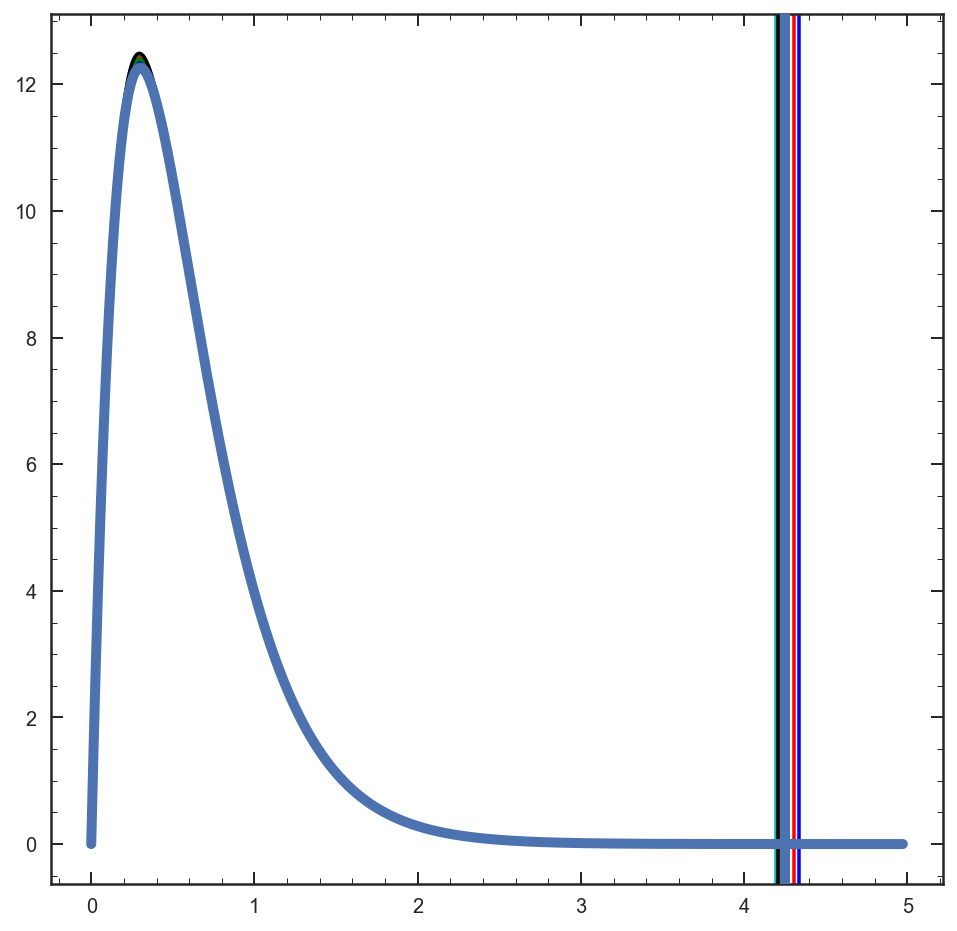

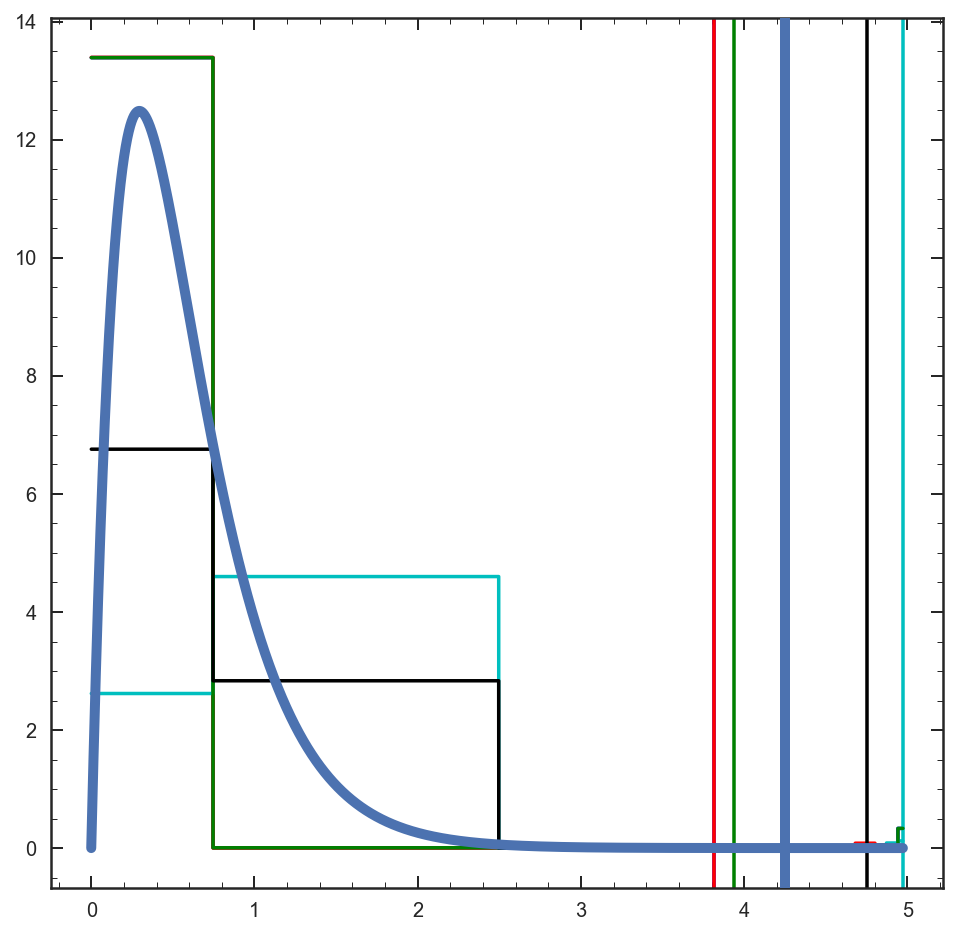

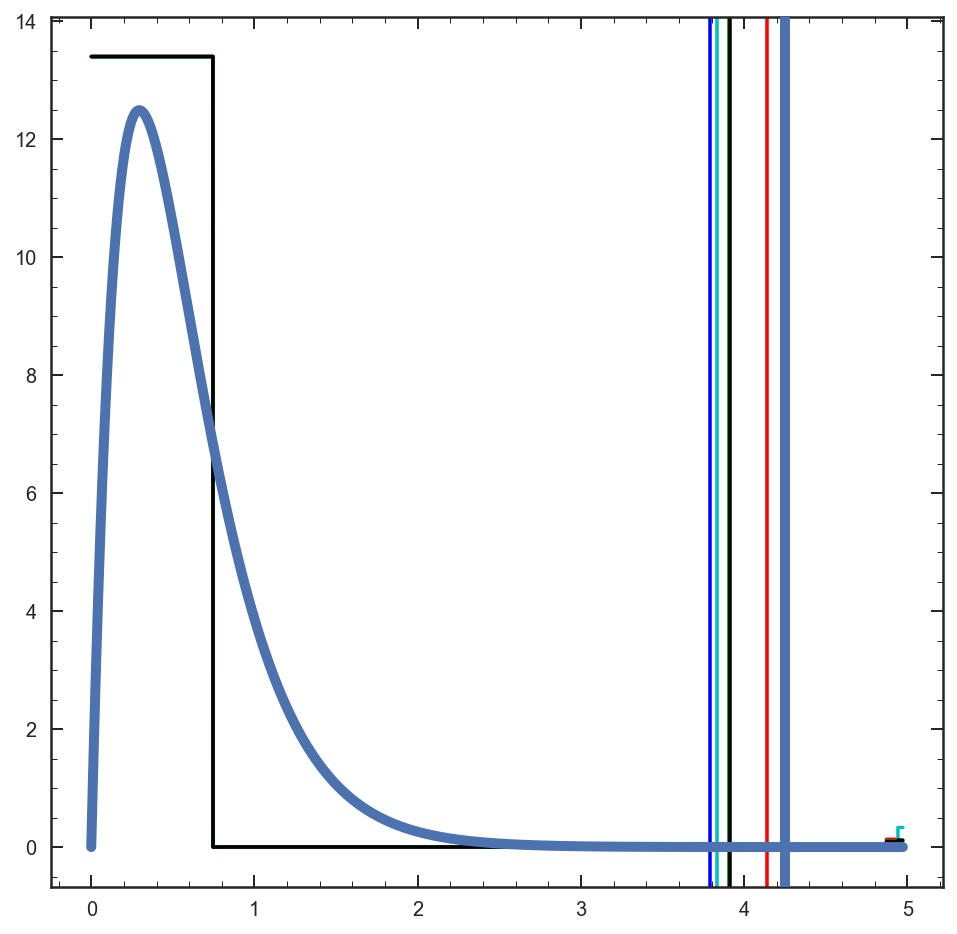

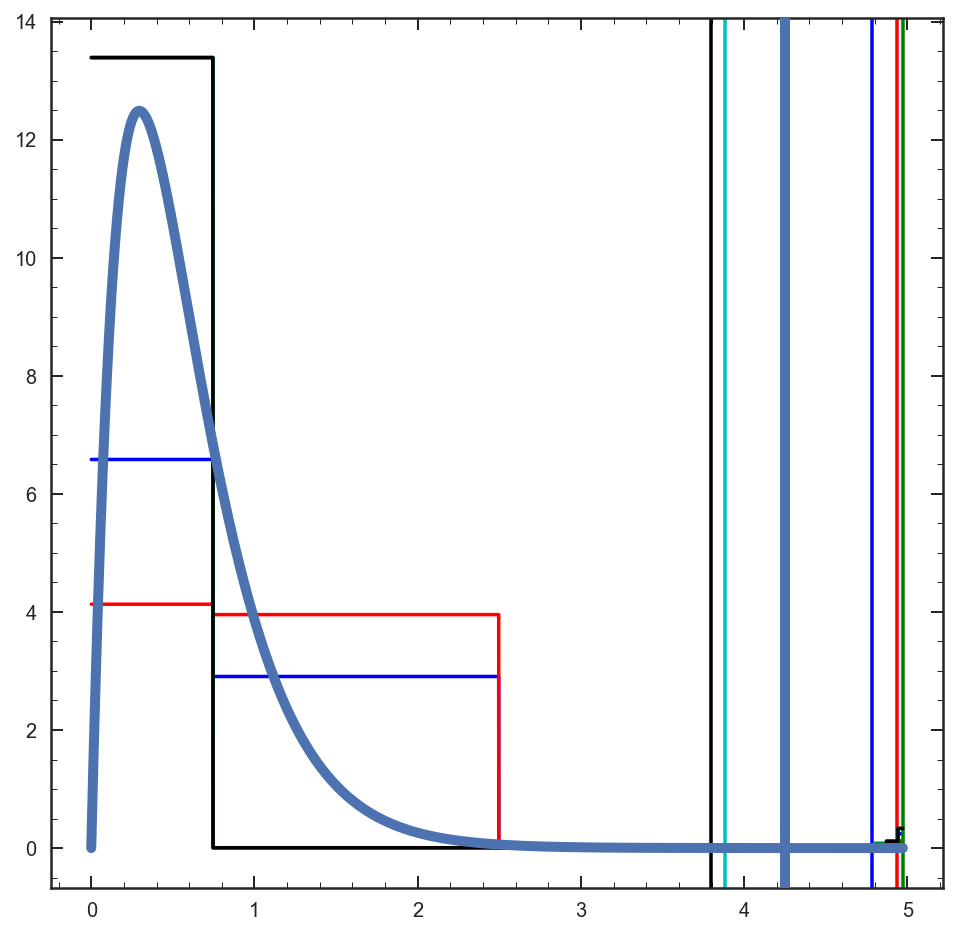

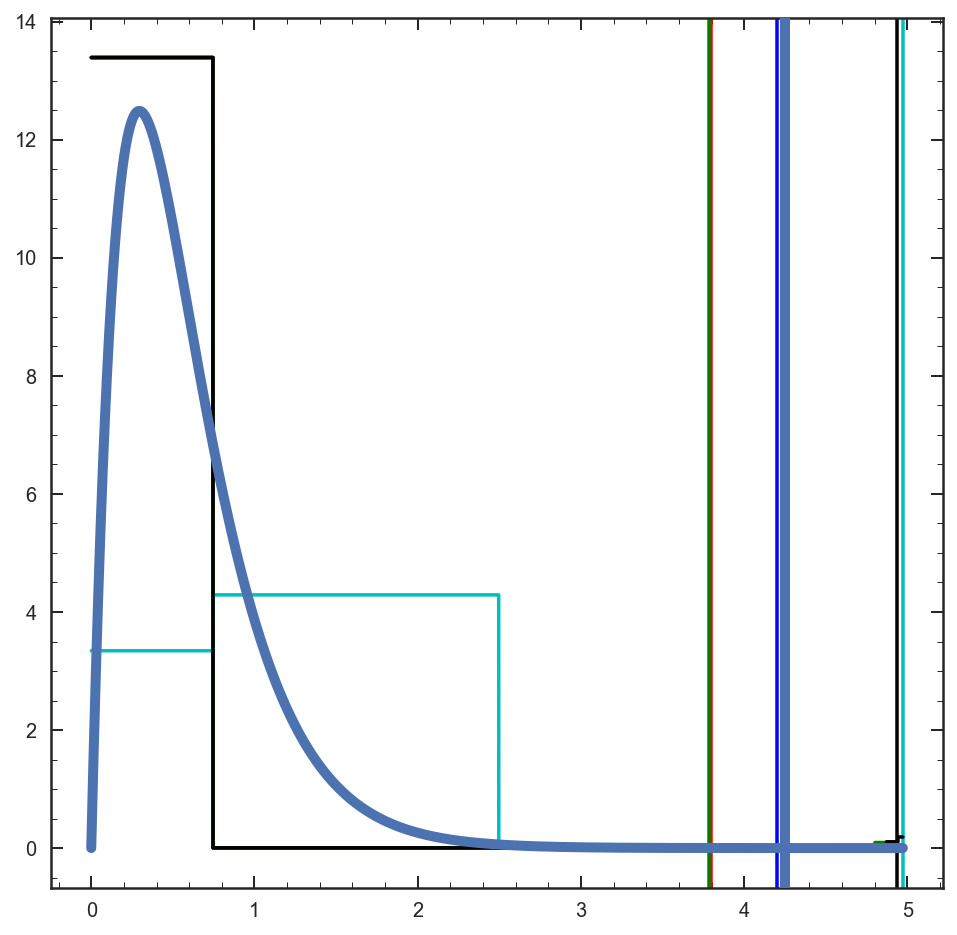

In [70]:
T= np.arange(0,Oldest_galaxy(1.25)+.001,.001)
sfh = T * np.exp(-T / 0.3)
sc_sfh = scale_sfr(sfh, T,1)

colors = ['b','r','c','g','k']

plt.figure(figsize=[8,8])
plt.plot(T, sc_sfh, zorder=9, linewidth = 5)
plt.axvline(4.25, zorder=9, linewidth = 5)
for i in range(5):
    t,pt = np.load('../data/posteriors/sim_test_delay_to_delay_multi_{0}_Pt.npy'.format(i + 1))
    a,pa = np.load('../data/posteriors/sim_test_delay_to_delay_multi_{0}_Pa.npy'.format(i + 1))
    
    tau = t[pt == max(pt)][0]
    age = a[pa == max(pa)][0]
    
    sfh = T * np.exp(-T / tau)
    sc_sfh = scale_sfr(sfh, T, 1)
    plt.plot(T,sc_sfh, color = colors[i])
    plt.axvline(age, color = colors[i])
    
plt.figure(figsize=[8,8])
plt.plot(T, sc_sfh, zorder=9, linewidth = 5)
plt.axvline(4.25, zorder=9, linewidth = 5)
for i in range(5):
    md = np.zeros(10)

    for ii in range(10):
        t,pt = np.load('../data/posteriors/sim_test_delay_to_tab_{0}_Pm{1}.npy'.format(i+1,ii+1))
        md[ii] = t[pt == max(pt)]
    TIME, SFR, tmax = convert_sfh(agebins, md)
    sc_SFR = scale_sfr(SFR, TIME,1)
    a,pa = np.load('../data/posteriors/sim_test_delay_to_tab_{0}_Pa.npy'.format(i+1))
    age = a[pa == max(pa)][0]
    
    plt.plot(TIME, sc_SFR, color = colors[i])
    plt.axvline(age, color = colors[i])

plt.figure(figsize=[8,8])
plt.plot(T, sc_sfh, zorder=9, linewidth = 5)
plt.axvline(4.25, zorder=9, linewidth = 5)
for i in range(5):
    md = np.zeros(7)

    for ii in range(7):
        t,pt = np.load('../data/posteriors/sim_test_delay_to_tab_lessbin_{0}_Pm{1}.npy'.format(i+1,ii+1))
        md[ii] = t[pt == max(pt)]
    TIME, SFR, tmax = convert_sfh(agebins2, md)
    sc_SFR = scale_sfr(SFR, TIME,1)
    a,pa = np.load('../data/posteriors/sim_test_delay_to_tab_lessbin_{0}_Pa.npy'.format(i+1))
    age = a[pa == max(pa)][0]
    
    plt.plot(TIME, sc_SFR, color = colors[i])
    plt.axvline(age, color = colors[i])
    
plt.figure(figsize=[8,8])
plt.plot(T, sc_sfh, zorder=9, linewidth = 5)
plt.axvline(4.25, zorder=9, linewidth = 5)
for i in range(5):
    md = np.zeros(10)

    for ii in range(10):
        t,pt = np.load('../data/posteriors/sim_test_delay_to_tab_sclmass_{0}_Pm{1}.npy'.format(i+1,ii+1))
        md[ii] = t[pt == max(pt)]
    TIME, SFR, tmax = convert_sfh(agebins, md)
    sc_SFR = scale_sfr(SFR, TIME,1)
    a,pa = np.load('../data/posteriors/sim_test_delay_to_tab_sclmass_{0}_Pa.npy'.format(i+1))
    age = a[pa == max(pa)][0]
    
    plt.plot(TIME, sc_SFR, color = colors[i])
    plt.axvline(age, color = colors[i])
    
plt.figure(figsize=[8,8])
plt.plot(T, sc_sfh, zorder=9, linewidth = 5)
plt.axvline(4.25, zorder=9, linewidth = 5)
for i in range(5):
    md = np.zeros(10)

    for ii in range(10):
        t,pt = np.load('../data/posteriors/sim_test_delay_to_tab_sclspec_{0}_Pm{1}.npy'.format(i+1,ii+1))
        md[ii] = t[pt == max(pt)]
    TIME, SFR, tmax = convert_sfh(agebins, md)
    sc_SFR = scale_sfr(SFR, TIME,1)
    a,pa = np.load('../data/posteriors/sim_test_delay_to_tab_sclspec_{0}_Pa.npy'.format(i+1))
    age = a[pa == max(pa)][0]
    
    plt.plot(TIME, sc_SFR, color = colors[i])
    plt.axvline(age, color = colors[i])
    

In [58]:
def get_massdist(sfr, LBT):
    md = sfr
    hrtime = np.round(np.arange(0,LBT[-1],0.001),2)
    dt = 0.001
    mass = np.zeros(len(hrtime))
    mbu = 0
    u = 0
    for i in range(len(hrtime)):
        if hrtime[i] > LBT[u]:
            u+=1
        mass[i] = mbu
        mbu += md[u] * dt

    mass = mass[hrtime < bft]
    hrtime = hrtime[hrtime < bft]
    mass /= mass[-1]

    return hrtime,mass

def scale_sfr(sfr, LBT, fitmass):
    md = sfr
    hrtime = np.round(np.arange(0,LBT[-1],0.001),2)
    dt = 0.001
    mass = np.zeros(len(hrtime))
    mbu = 0
    u = 0
    for i in range(len(hrtime)):
        if hrtime[i] > LBT[u]:
            u+=1
        mass[i] = mbu
        mbu += md[u] * dt

    mass = mass[hrtime < bft]
    hrtime = hrtime[hrtime < bft]    
    
    return sfr / max(mass) * 10**fitmass 

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


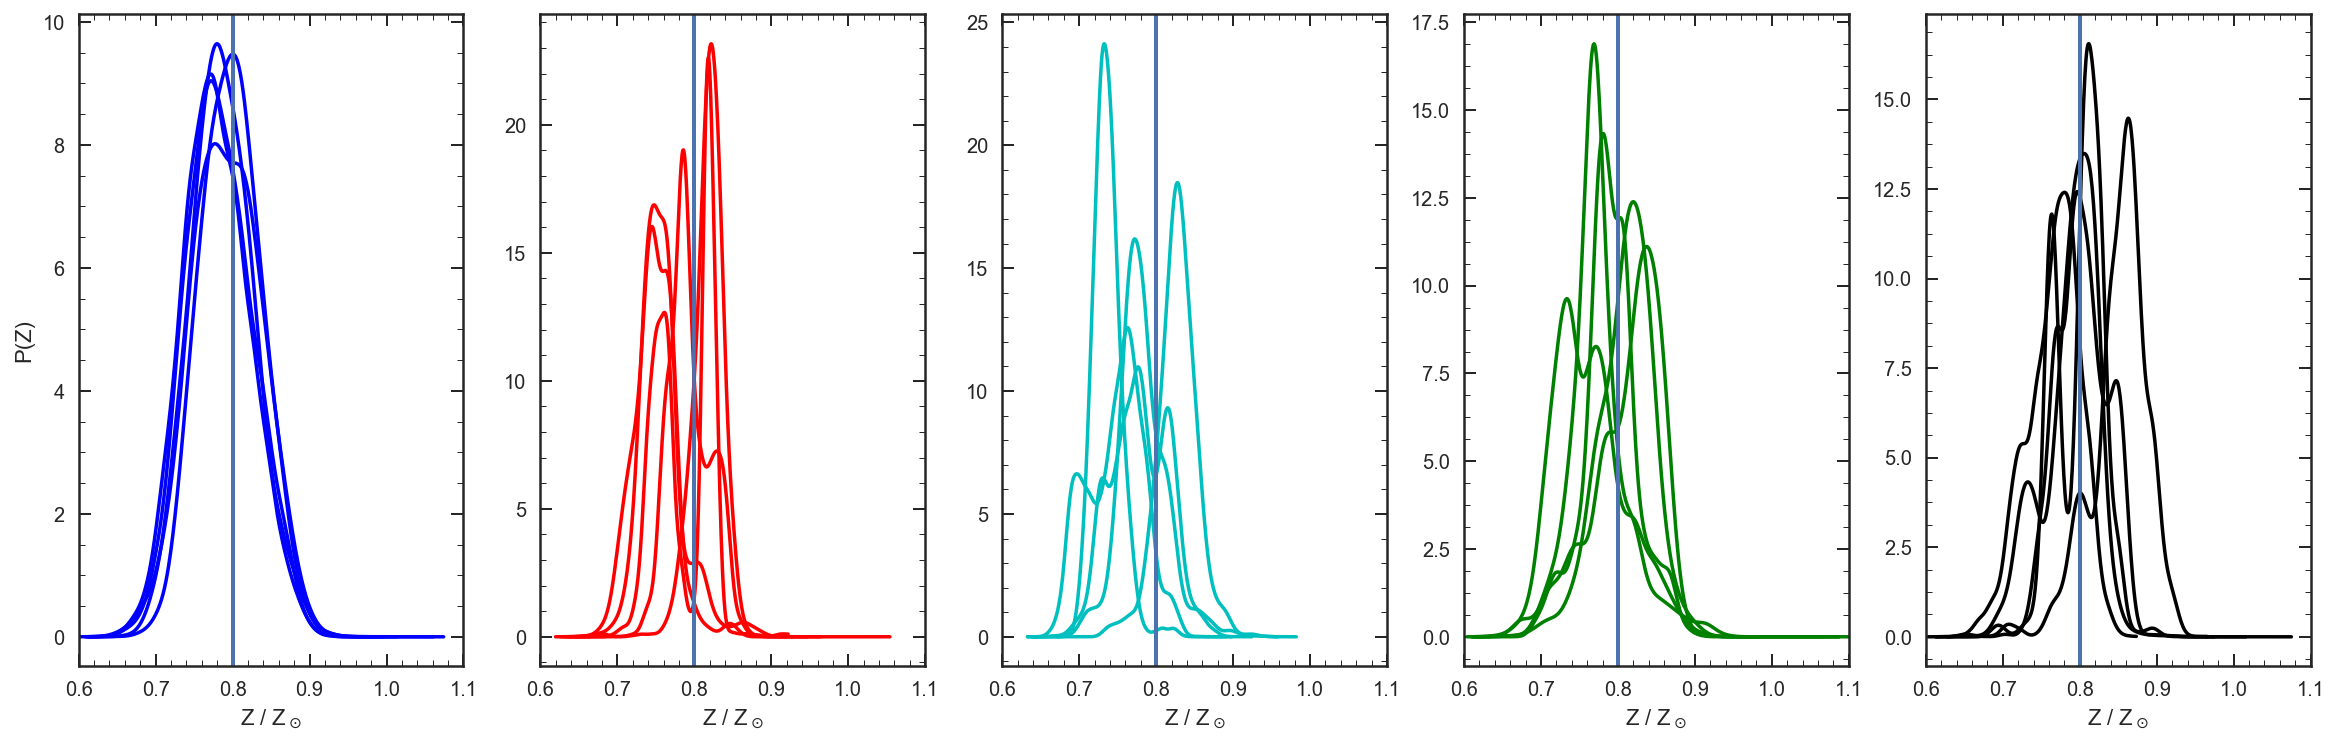

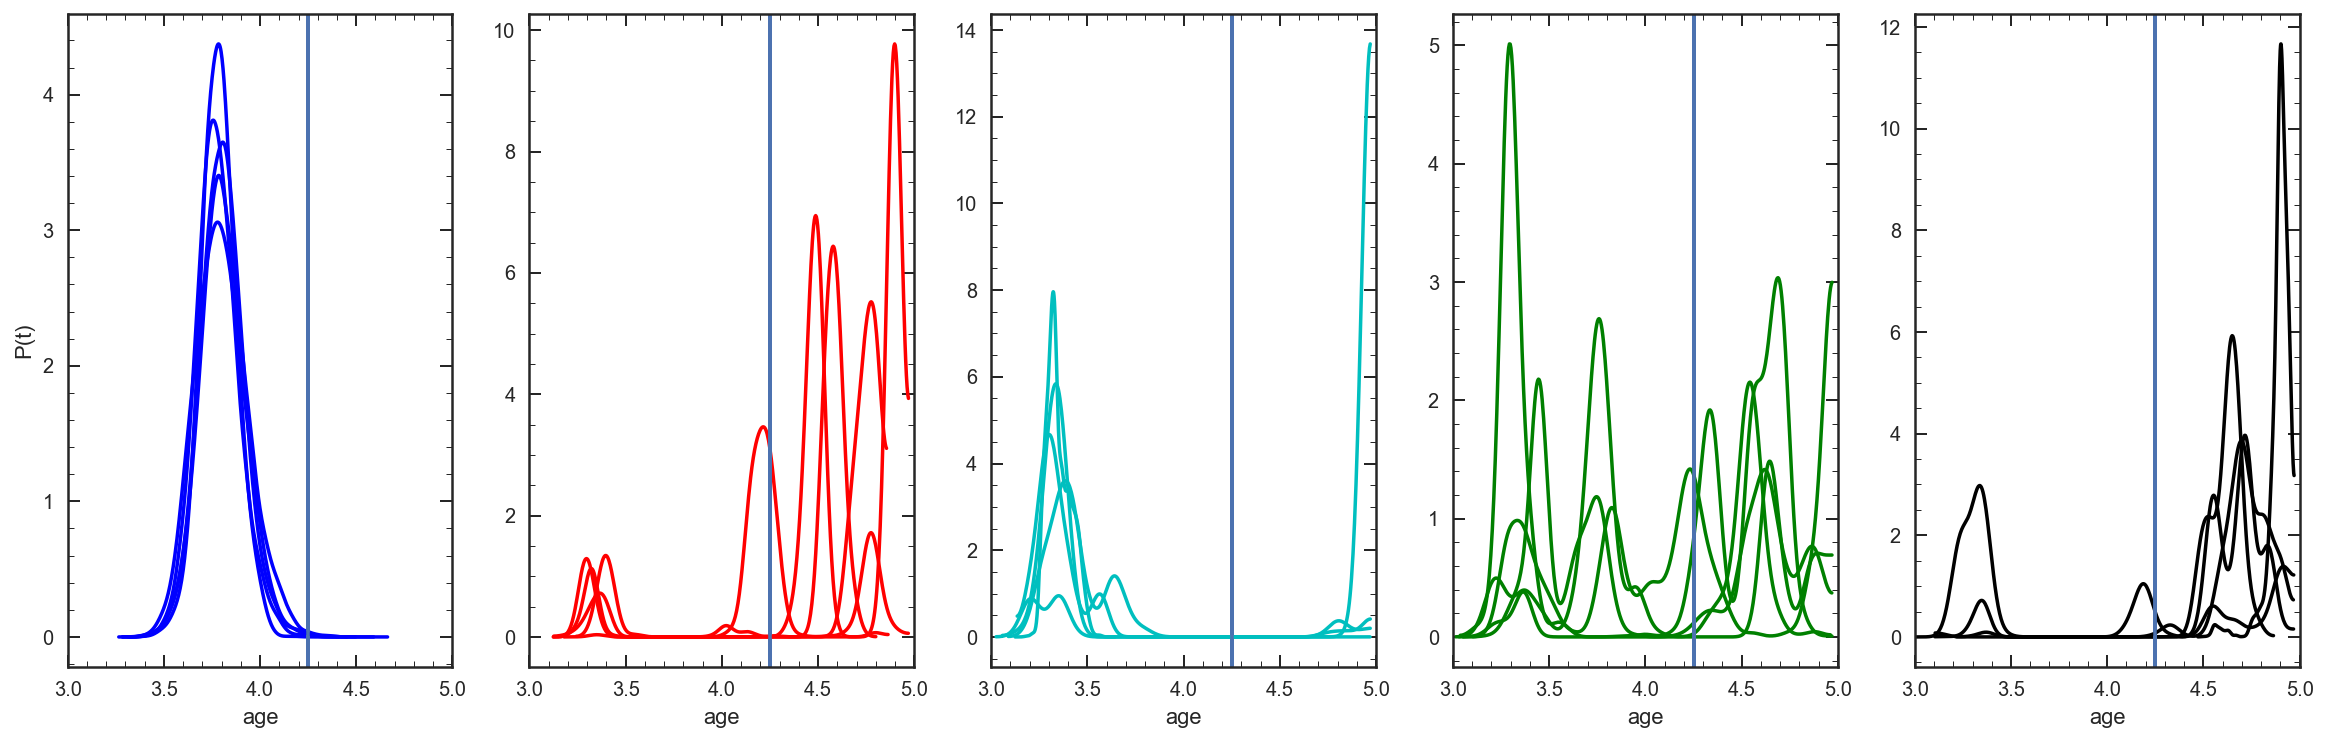

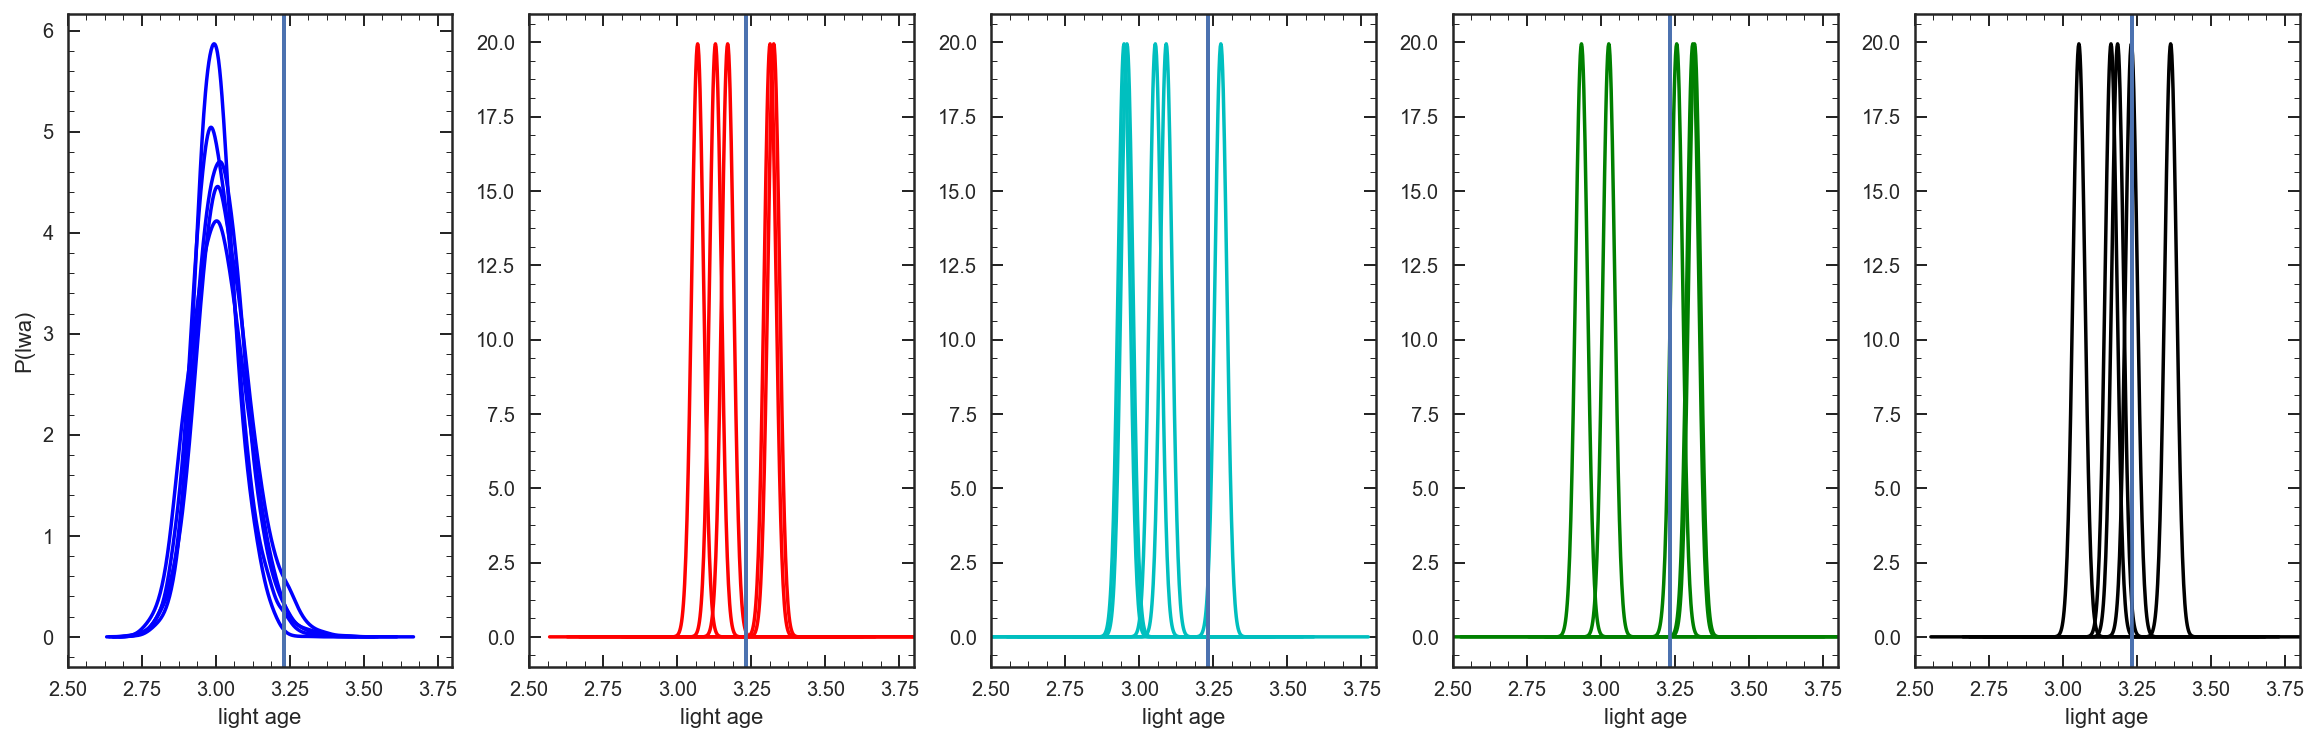

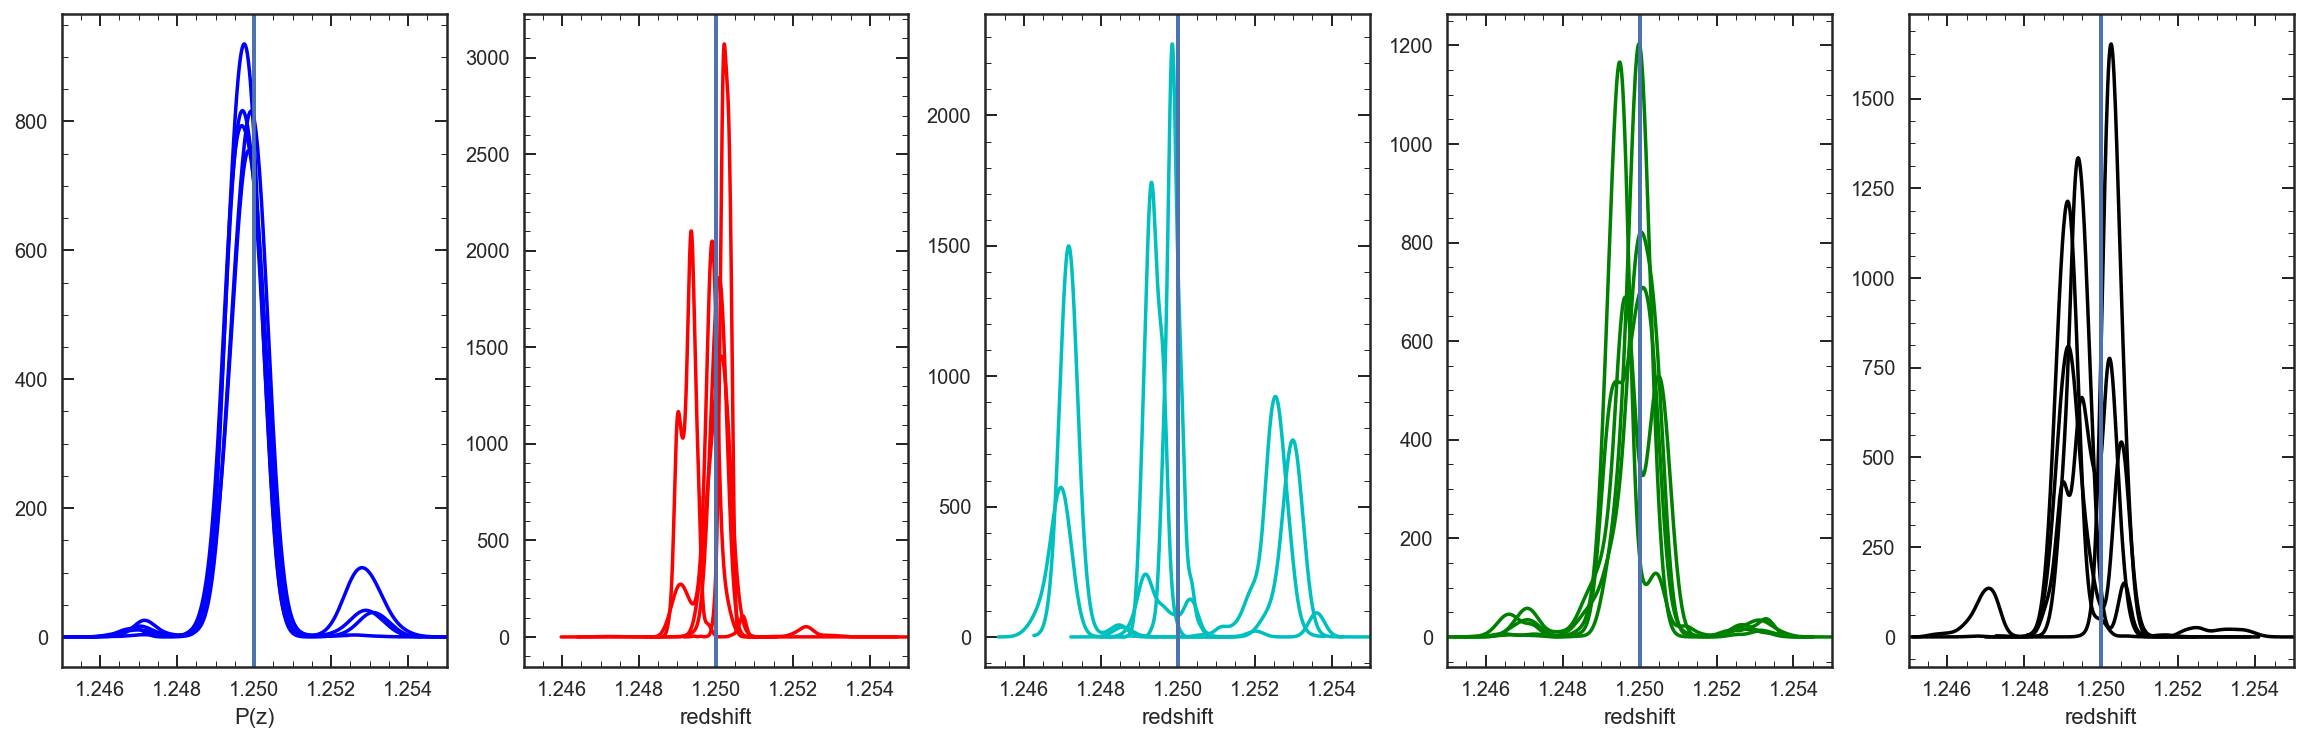

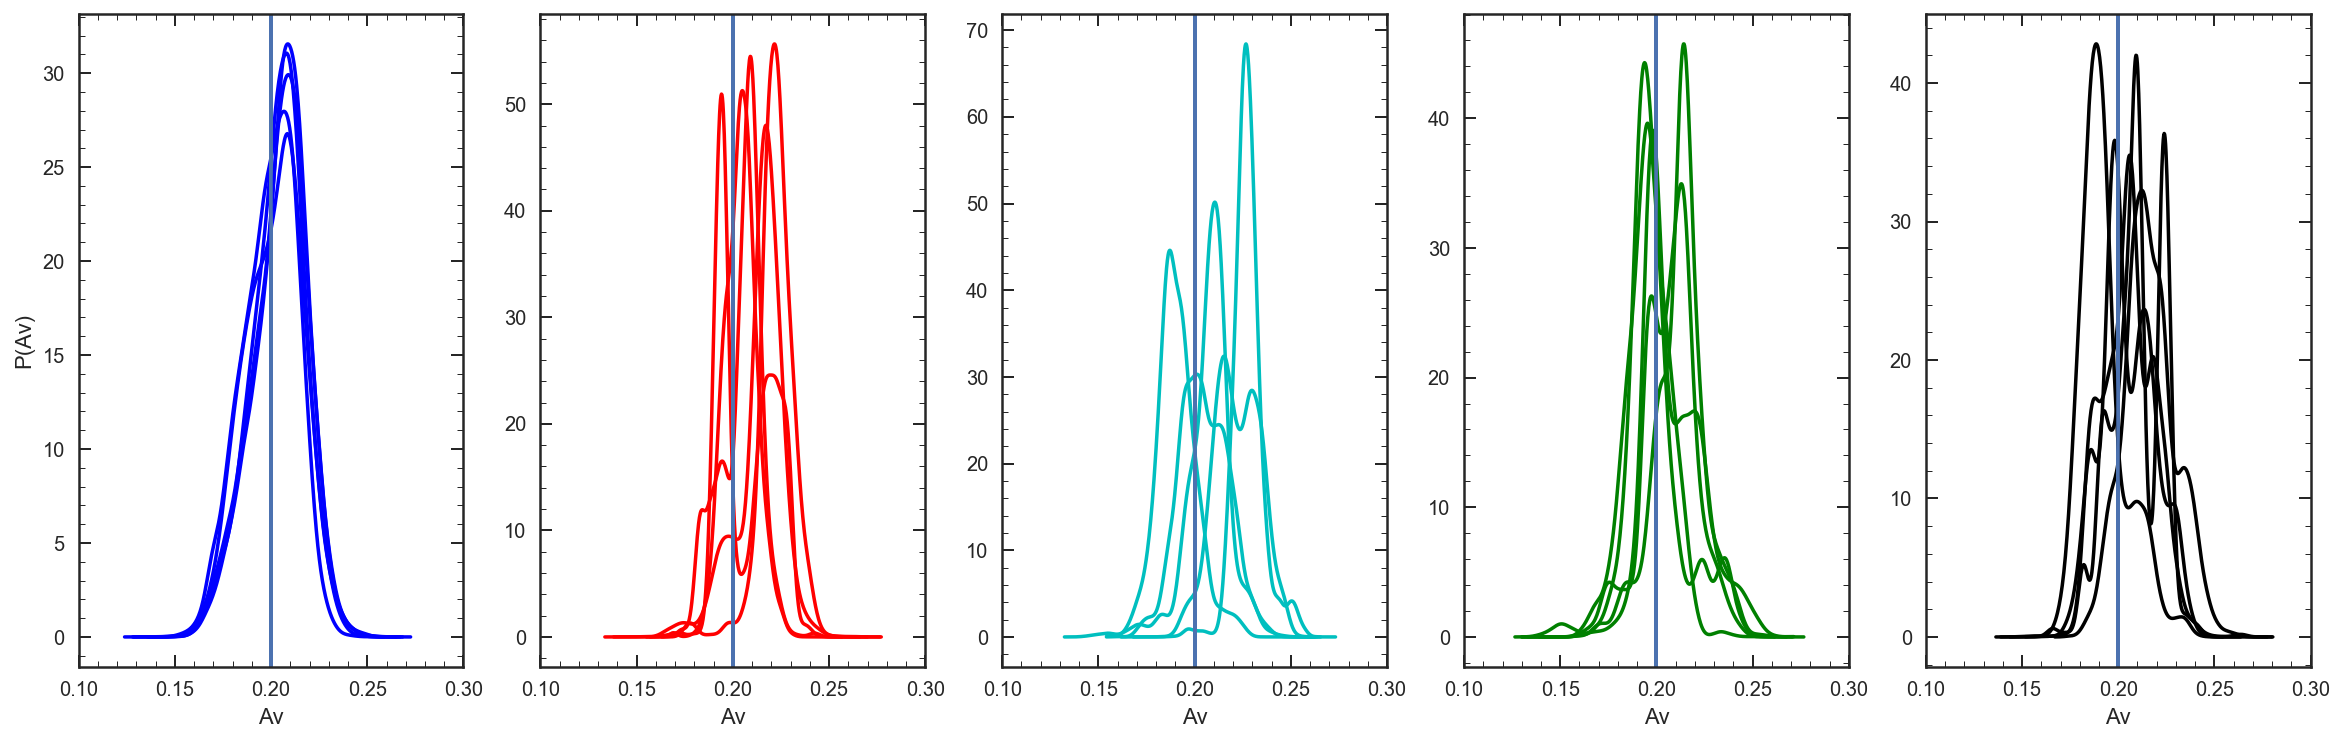

In [49]:
gs = GridSpec(1,5)
plt.figure(figsize=[20,6])
for i in range(5):
    m,Pm = np.load('../data/posteriors/sim_test_tab_to_delay_multi_{0}_Pm.npy'.format(i+1))
    plt.subplot(gs[0])
    plt.plot(m,Pm,'b')
    plt.axvline(0.8)
    plt.xlim(0.6,1.1)
    plt.xlabel('Z / Z$_\odot$')
    plt.ylabel('P(Z)')
    
    m,Pm = np.load('../data/posteriors/sim_test_tab_to_tab_{0}_Pm.npy'.format(i+1))
    plt.subplot(gs[1])
    plt.plot(m,Pm,'r')
    plt.axvline(0.8)
    plt.xlim(0.6,1.1)
    plt.xlabel('Z / Z$_\odot$')
    
    m,Pm = np.load('../data/posteriors/sim_test_tab_to_tab_lessbin_{0}_Pm.npy'.format(i+1))
    plt.subplot(gs[2])
    plt.plot(m,Pm,'c')
    plt.axvline(0.8)
    plt.xlim(0.6,1.1)
    plt.xlabel('Z / Z$_\odot$')
    
    m,Pm = np.load('../data/posteriors/sim_test_tab_to_tab_sclmass_{0}_Pm.npy'.format(i+1))
    plt.subplot(gs[3])
    plt.plot(m,Pm,'g')
    plt.axvline(0.8)
    plt.xlim(0.6,1.1)
    plt.xlabel('Z / Z$_\odot$')

    m,Pm = np.load('../data/posteriors/sim_test_tab_to_tab_sclspec_{0}_Pm.npy'.format(i+1))
    plt.subplot(gs[4])
    plt.plot(m,Pm,'k')
    plt.axvline(0.8)
    plt.xlim(0.6,1.1)
    plt.xlabel('Z / Z$_\odot$')
    
gs = GridSpec(1,5)
plt.figure(figsize=[20,6])
for i in range(5):
    m,Pm = np.load('../data/posteriors/sim_test_tab_to_delay_multi_{0}_Pa.npy'.format(i+1))
    plt.subplot(gs[0])
    plt.plot(m,Pm,'b')
    plt.axvline(4.25)
    plt.xlim(3,5)
    plt.xlabel('age')
    plt.ylabel('P(t)')
    
    m,Pm = np.load('../data/posteriors/sim_test_tab_to_tab_{0}_Pa.npy'.format(i+1))
    plt.subplot(gs[1])
    plt.plot(m,Pm,'r')
    plt.axvline(4.25)
    plt.xlim(3,5)
    plt.xlabel('age')
    
    m,Pm = np.load('../data/posteriors/sim_test_tab_to_tab_lessbin_{0}_Pa.npy'.format(i+1))
    plt.subplot(gs[2])
    plt.plot(m,Pm,'c')
    plt.axvline(4.25)
    plt.xlim(3,5)
    plt.xlabel('age')
    
    m,Pm = np.load('../data/posteriors/sim_test_tab_to_tab_sclmass_{0}_Pa.npy'.format(i+1))
    plt.subplot(gs[3])
    plt.plot(m,Pm,'g')
    plt.axvline(4.25)
    plt.xlim(3,5)
    plt.xlabel('age')

    m,Pm = np.load('../data/posteriors/sim_test_tab_to_tab_sclspec_{0}_Pa.npy'.format(i+1))
    plt.subplot(gs[4])
    plt.plot(m,Pm,'k')
    plt.axvline(4.25)
    plt.xlim(3,5)
    plt.xlabel('age')

gs = GridSpec(1,5)
plt.figure(figsize=[20,6])
for i in range(5):
    m,Pm = np.load('../data/posteriors/sim_test_tab_to_delay_multi_{0}_Plwa.npy'.format(i+1))
    plt.subplot(gs[0])
    plt.plot(m,Pm,'b')
    plt.axvline(lwa_tab)
    plt.xlabel('light age')
    plt.ylabel('P(lwa)')
    plt.xlim(2.5,3.8)
    
    m,Pm = np.load('../data/posteriors/sim_test_tab_to_tab_{0}_Plwa.npy'.format(i+1))
    plt.subplot(gs[1])
    plt.plot(m,Pm,'r')
    plt.axvline(lwa_tab)
    plt.xlabel('light age')
    plt.xlim(2.5,3.8)
    
    m,Pm = np.load('../data/posteriors/sim_test_tab_to_tab_lessbin_{0}_Plwa.npy'.format(i+1))
    plt.subplot(gs[2])
    plt.plot(m,Pm,'c')
    plt.axvline(lwa_tab)
    plt.xlabel('light age')
    plt.xlim(2.5,3.8)
    
    m,Pm = np.load('../data/posteriors/sim_test_tab_to_tab_sclmass_{0}_Plwa.npy'.format(i+1))
    plt.subplot(gs[3])
    plt.plot(m,Pm,'g')
    plt.axvline(lwa_tab)
    plt.xlabel('light age')
    plt.xlim(2.5,3.8)

    m,Pm = np.load('../data/posteriors/sim_test_tab_to_tab_sclspec_{0}_Plwa.npy'.format(i+1))
    plt.subplot(gs[4])
    plt.plot(m,Pm,'k')
    plt.axvline(lwa_tab)
    plt.xlabel('light age')
    plt.xlim(2.5,3.8)

gs = GridSpec(1,5)
plt.figure(figsize=[20,6])
for i in range(5):
    m,Pm = np.load('../data/posteriors/sim_test_tab_to_delay_multi_{0}_Pz.npy'.format(i+1))
    plt.subplot(gs[0])
    plt.plot(m,Pm,'b')
    plt.axvline(1.25)
    plt.xlabel('redshift')
    plt.xlabel('P(z)')
    plt.xlim(1.245,1.255)
    
    m,Pm = np.load('../data/posteriors/sim_test_tab_to_tab_{0}_Pz.npy'.format(i+1))
    plt.subplot(gs[1])
    plt.plot(m,Pm,'r')
    plt.axvline(1.25)
    plt.xlabel('redshift')
    plt.xlim(1.245,1.255)
    
    m,Pm = np.load('../data/posteriors/sim_test_tab_to_tab_lessbin_{0}_Pz.npy'.format(i+1))
    plt.subplot(gs[2])
    plt.plot(m,Pm,'c')
    plt.axvline(1.25)
    plt.xlabel('redshift')
    plt.xlim(1.245,1.255)
    
    m,Pm = np.load('../data/posteriors/sim_test_tab_to_tab_sclmass_{0}_Pz.npy'.format(i+1))
    plt.subplot(gs[3])
    plt.plot(m,Pm,'g')
    plt.axvline(1.25)
    plt.xlabel('redshift')
    plt.xlim(1.245,1.255)

    m,Pm = np.load('../data/posteriors/sim_test_tab_to_tab_sclspec_{0}_Pz.npy'.format(i+1))
    plt.subplot(gs[4])
    plt.plot(m,Pm,'k')
    plt.axvline(1.25)
    plt.xlabel('redshift')
    plt.xlim(1.245,1.255)
    
gs = GridSpec(1,5)
plt.figure(figsize=[20,6])
for i in range(5):
    m,Pm = np.load('../data/posteriors/sim_test_tab_to_delay_multi_{0}_Pd.npy'.format(i+1))
    plt.subplot(gs[0])
    plt.plot(m,Pm,'b')
    plt.axvline(0.2)
    plt.xlabel('Av')
    plt.ylabel('P(Av)')
    plt.xlim(0.1,0.3)
    
    m,Pm = np.load('../data/posteriors/sim_test_tab_to_tab_{0}_Pd.npy'.format(i+1))
    plt.subplot(gs[1])
    plt.plot(m,Pm,'r')
    plt.axvline(0.2)
    plt.xlabel('Av')
    plt.xlim(0.1,0.3)
    
    m,Pm = np.load('../data/posteriors/sim_test_tab_to_tab_lessbin_{0}_Pd.npy'.format(i+1))
    plt.subplot(gs[2])
    plt.plot(m,Pm,'c')
    plt.axvline(0.2)
    plt.xlabel('Av')
    plt.xlim(0.1,0.3)
    
    m,Pm = np.load('../data/posteriors/sim_test_tab_to_tab_sclmass_{0}_Pd.npy'.format(i+1))
    plt.subplot(gs[3])
    plt.plot(m,Pm,'g')
    plt.axvline(0.2)
    plt.xlabel('Av')
    plt.xlim(0.1,0.3)

    m,Pm = np.load('../data/posteriors/sim_test_tab_to_tab_sclspec_{0}_Pd.npy'.format(i+1))
    plt.subplot(gs[4])
    plt.plot(m,Pm,'k')
    plt.axvline(0.2)
    plt.xlabel('Av')
    plt.xlim(0.1,0.3)
    

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


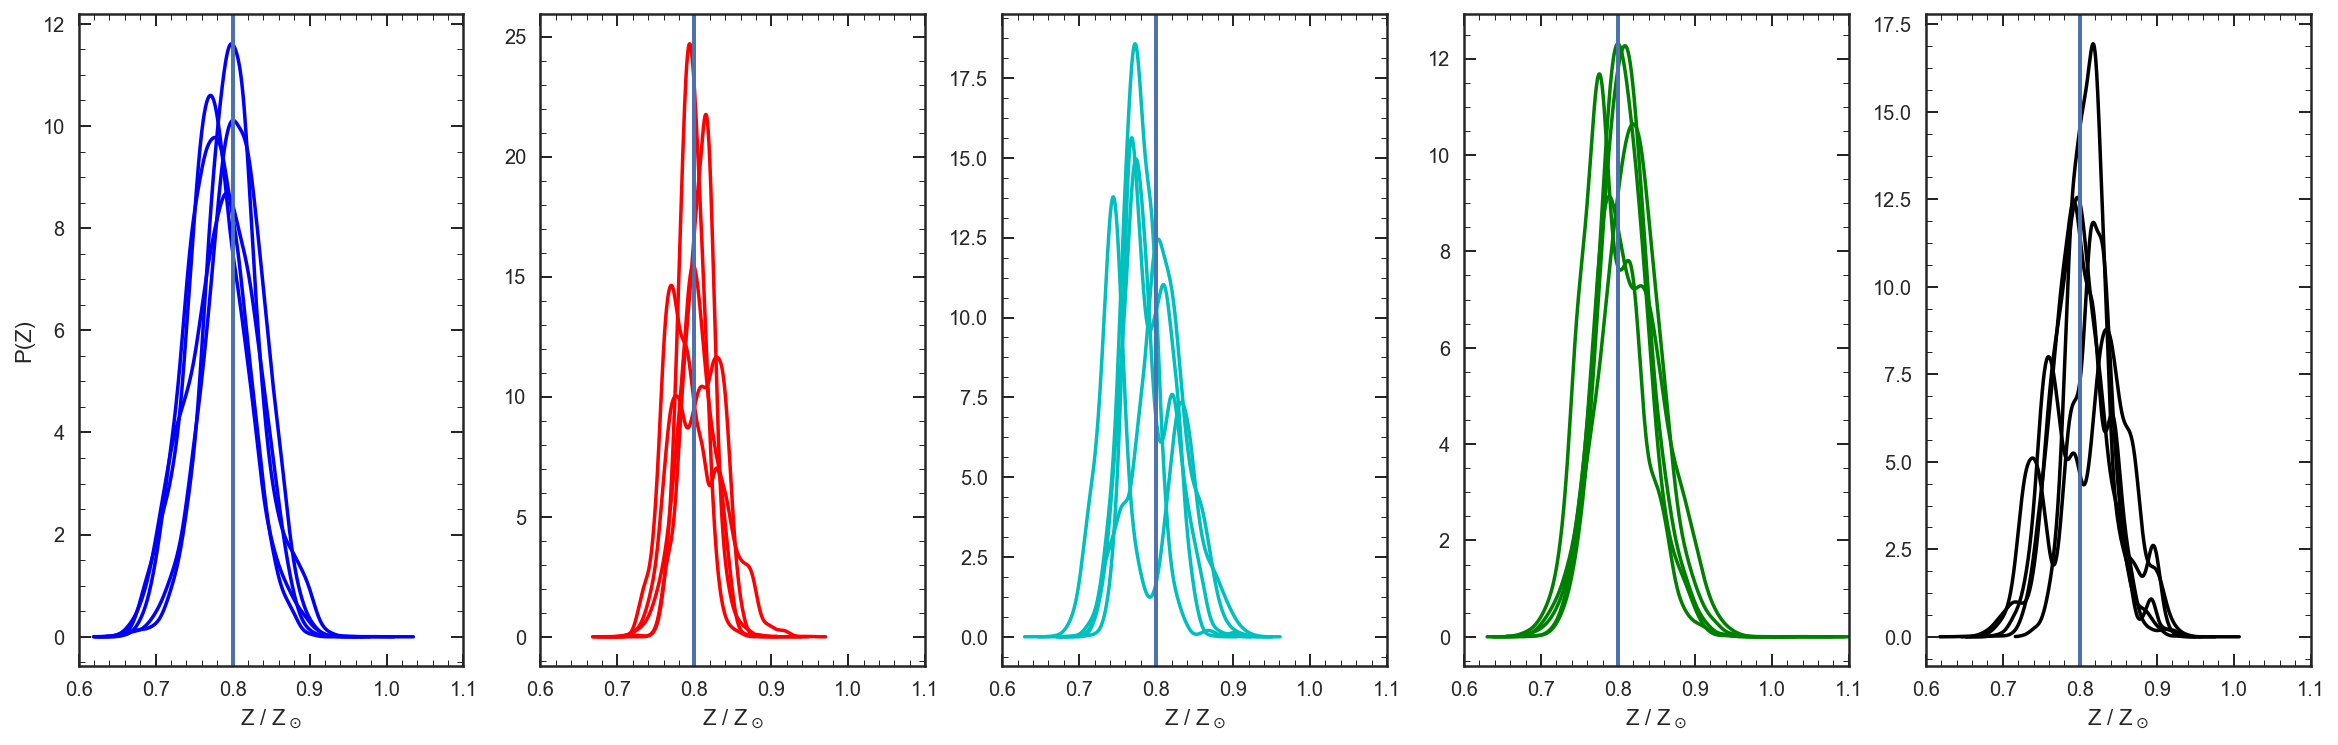

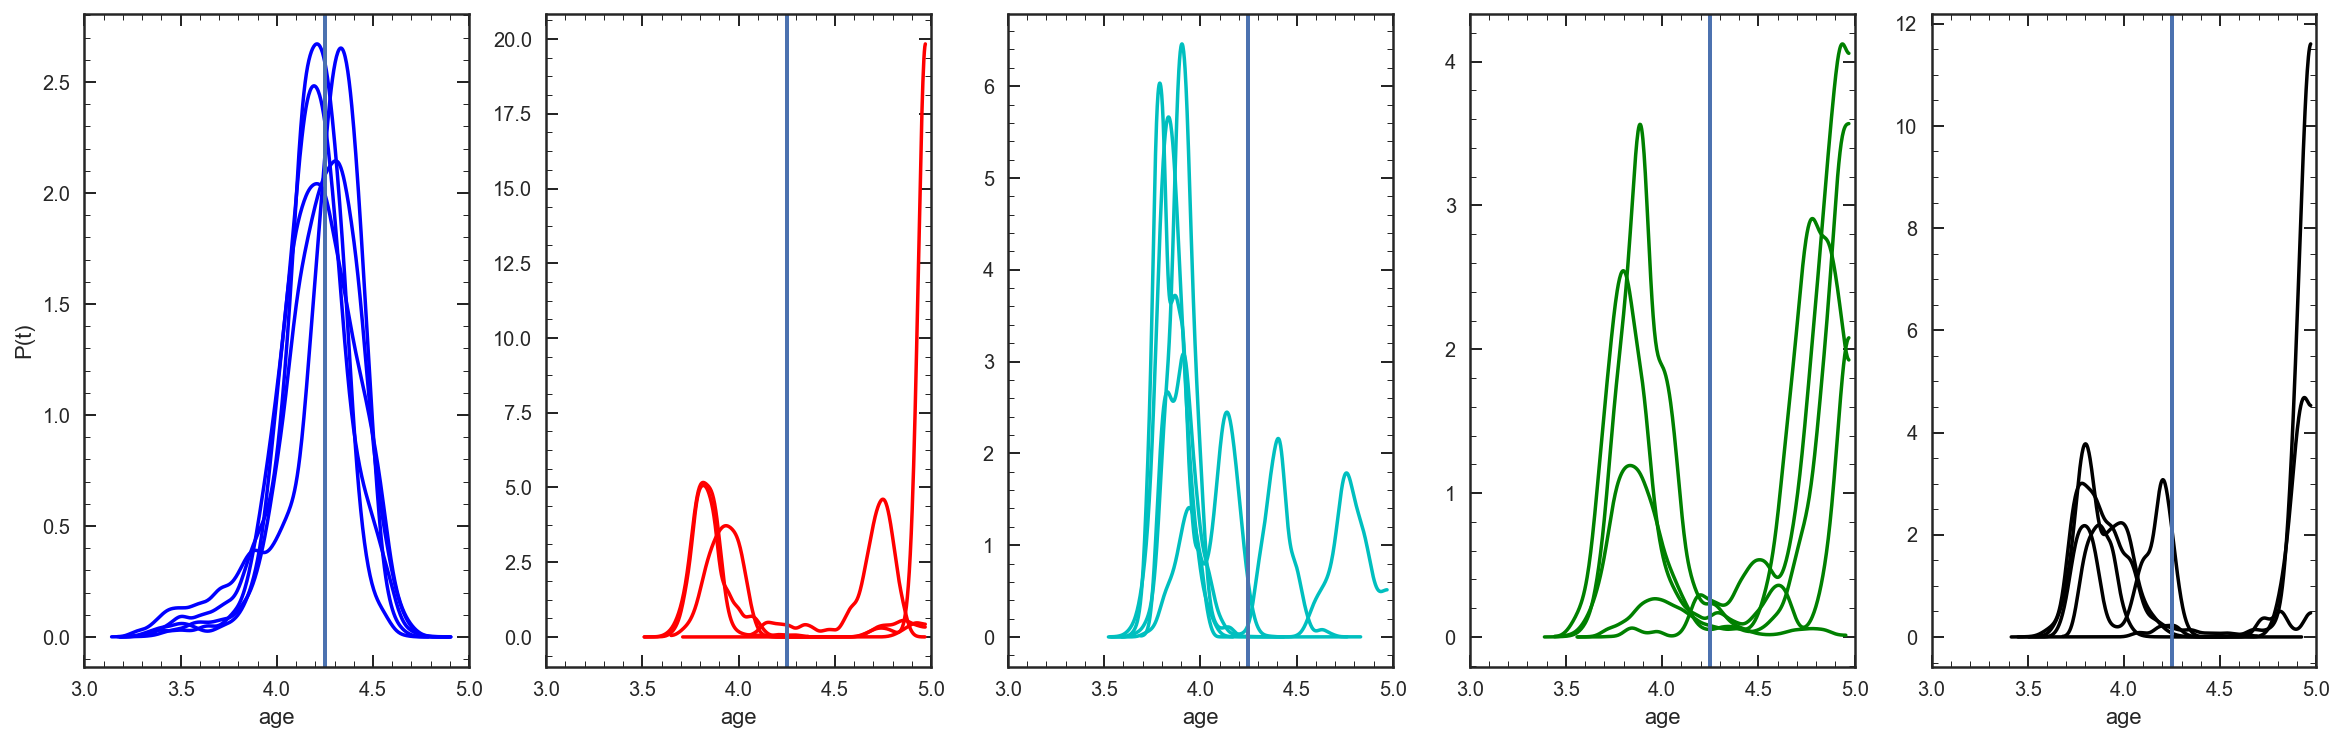

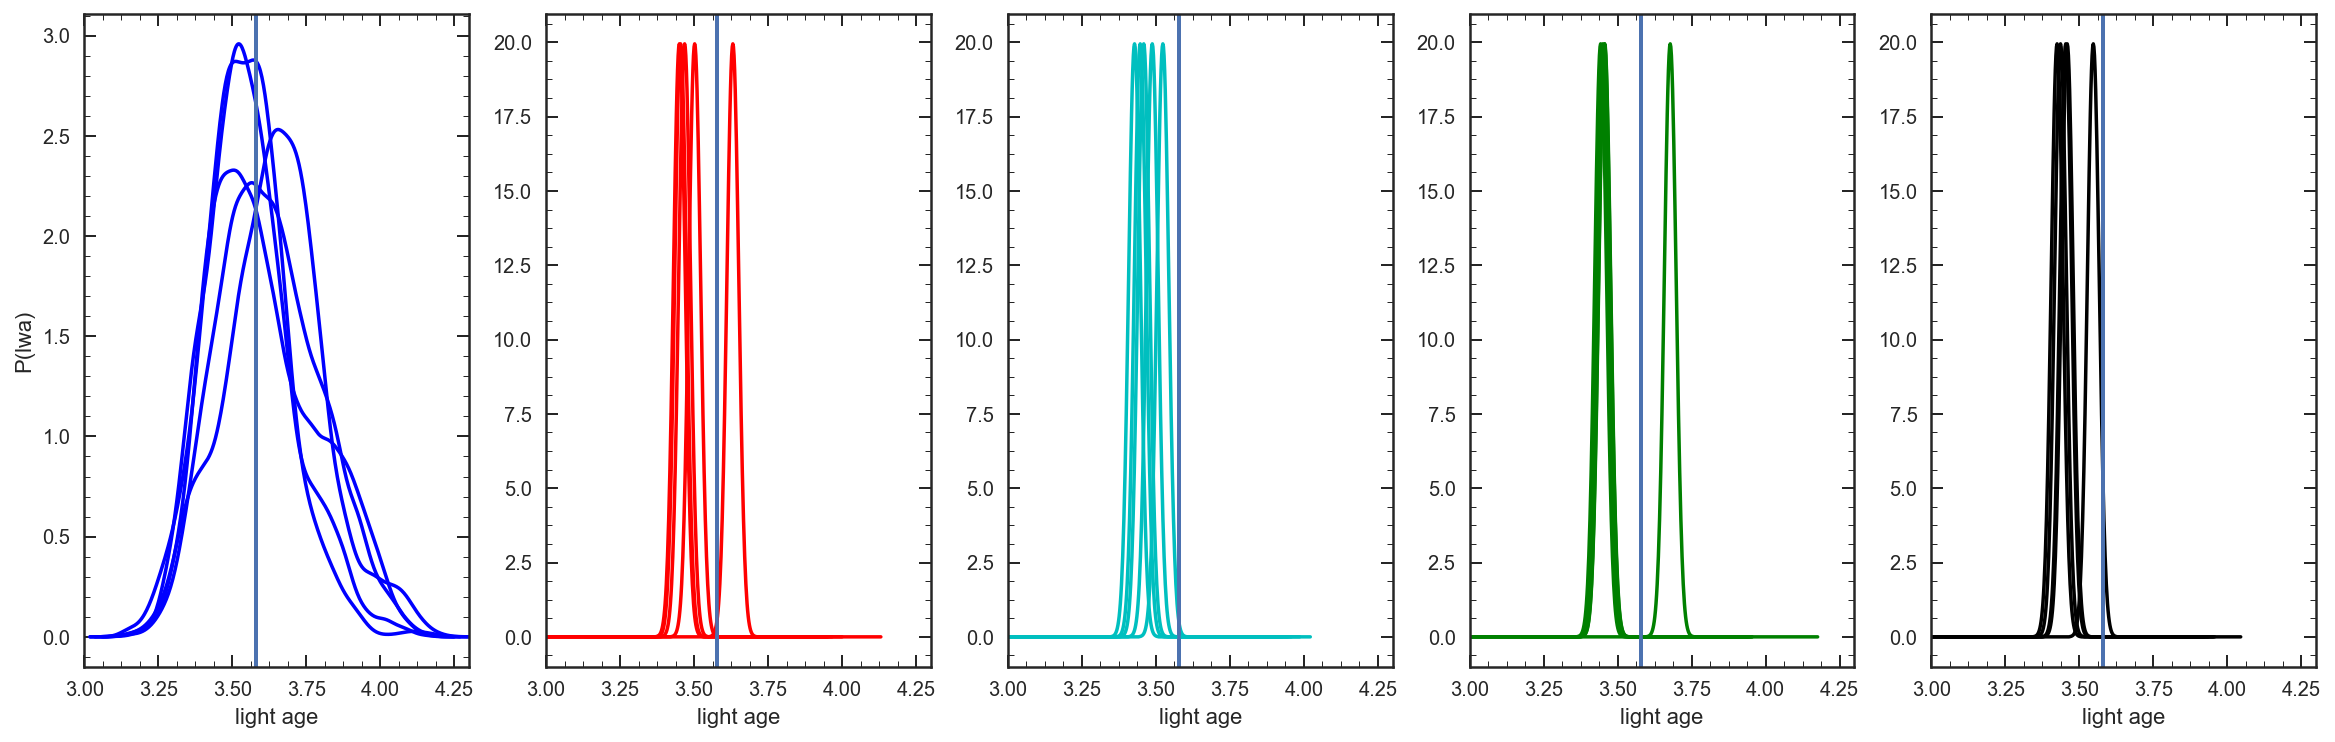

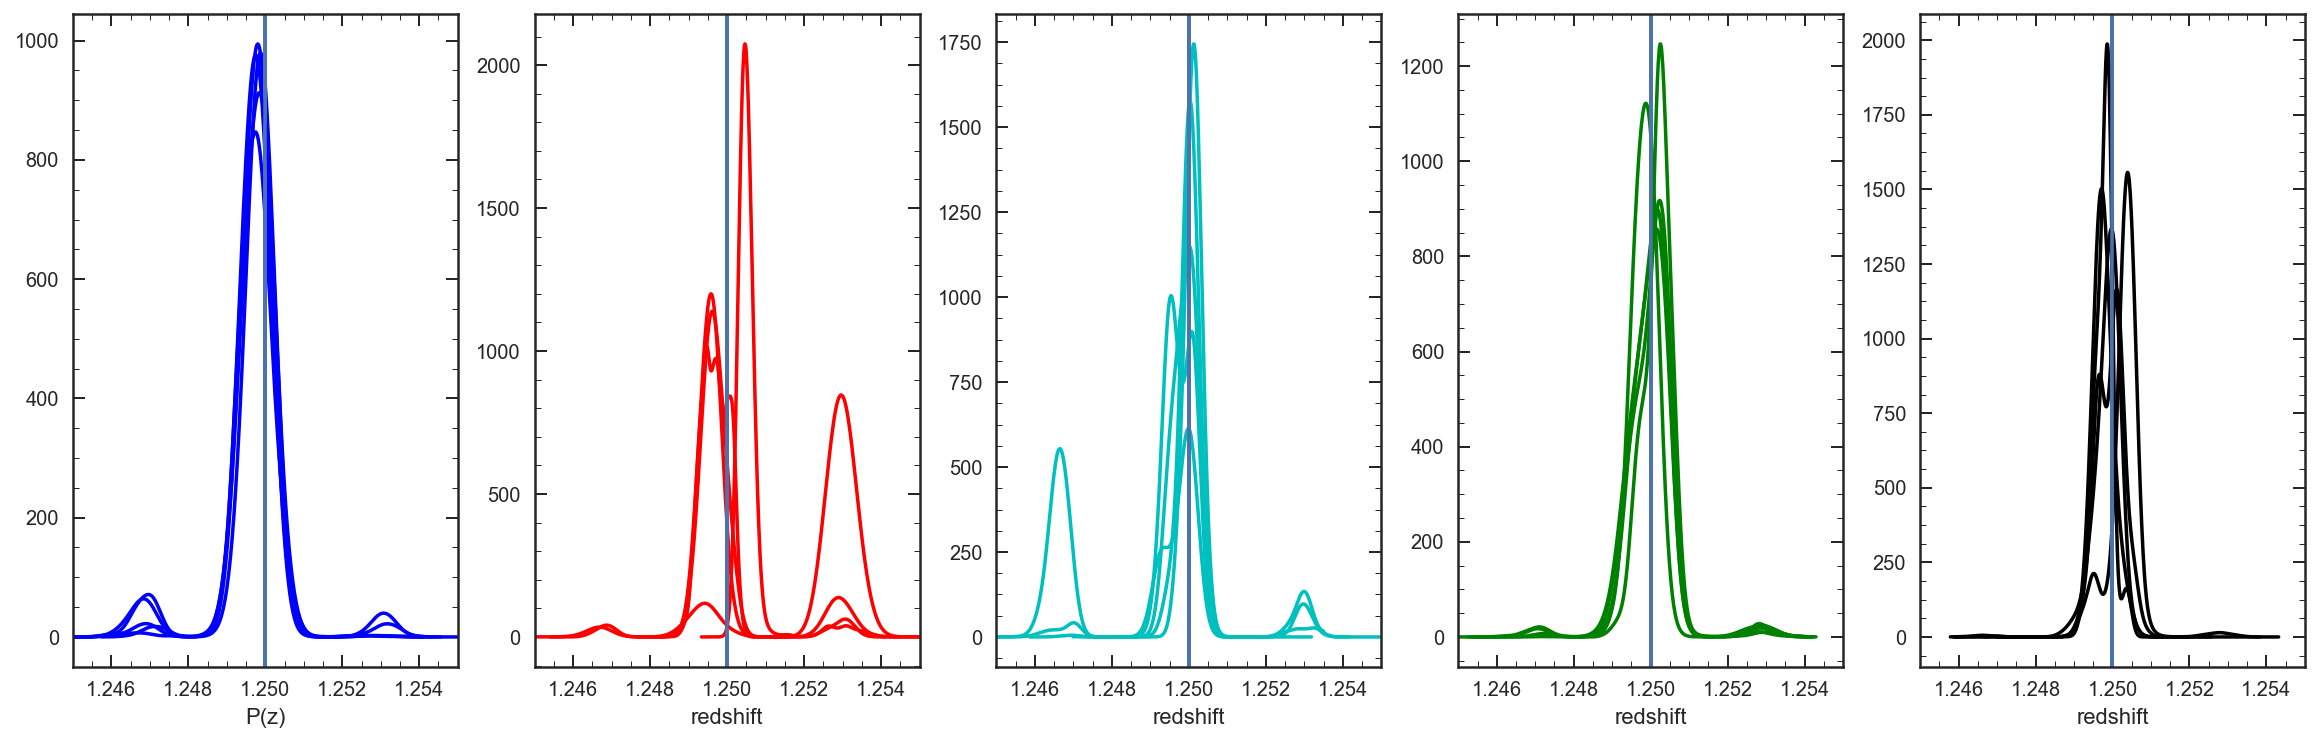

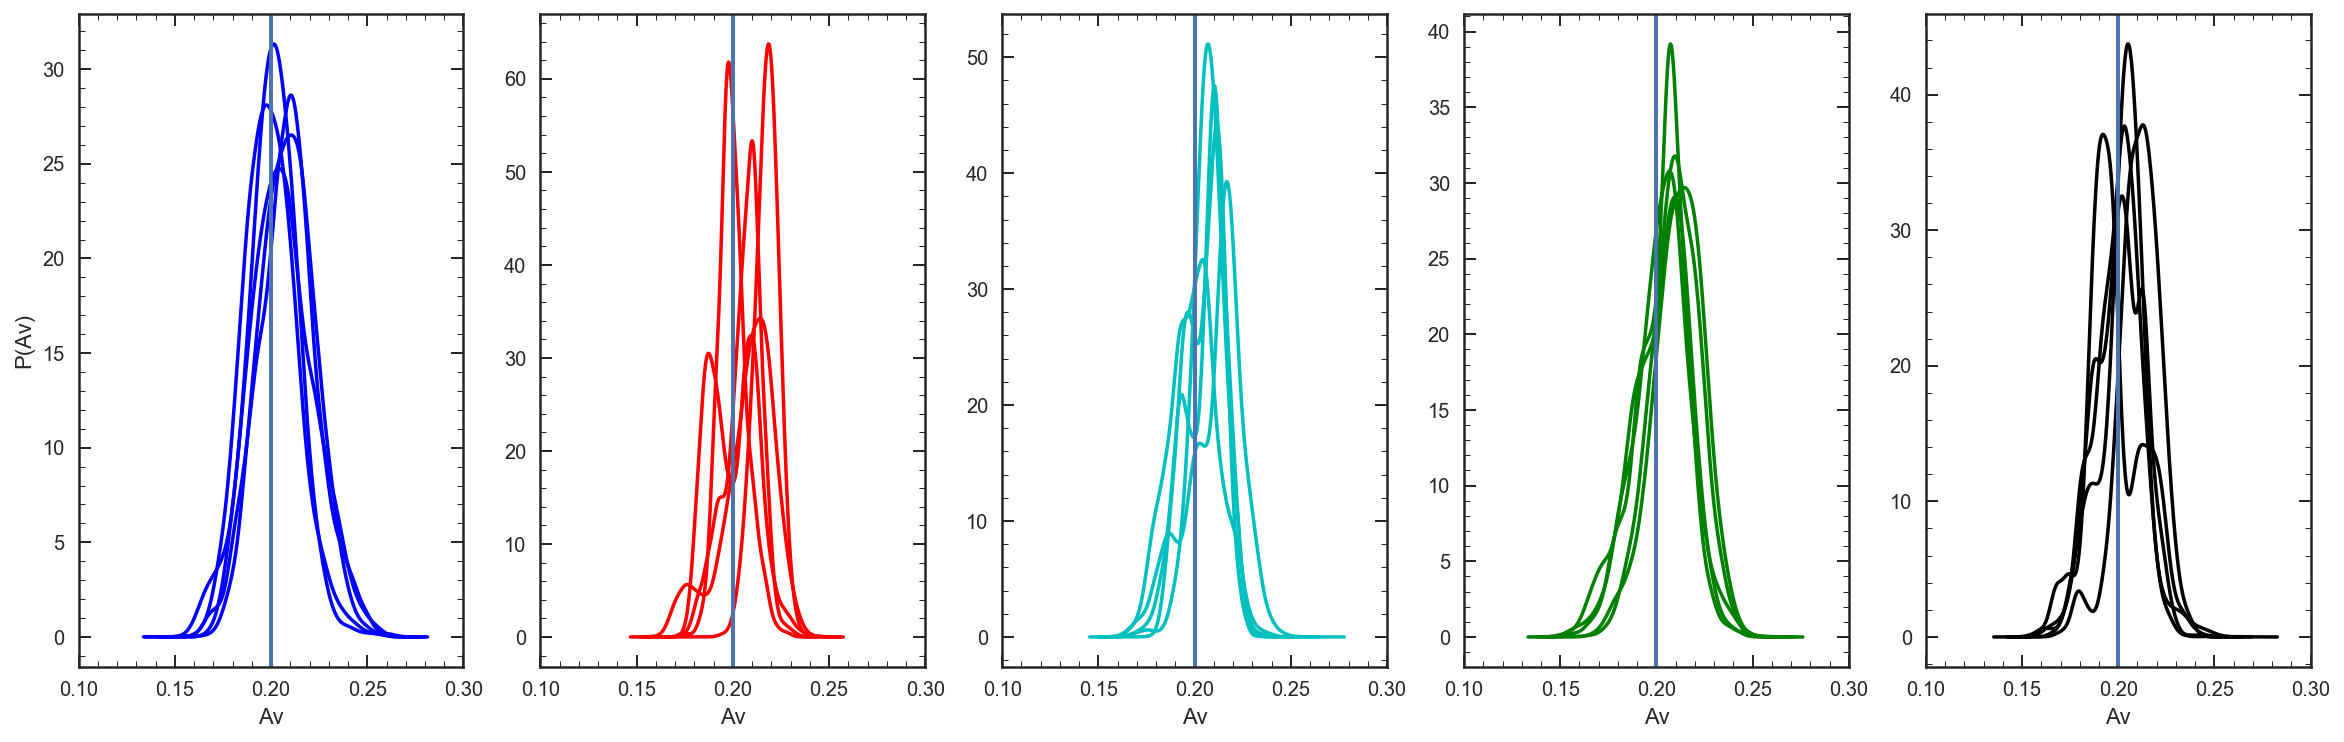

In [52]:
gs = GridSpec(1,5)
plt.figure(figsize=[20,6])
for i in range(5):
    m,Pm = np.load('../data/posteriors/sim_test_delay_to_delay_multi_{0}_Pm1.npy'.format(i+1))
    plt.subplot(gs[0])
    plt.plot(m,Pm,'b')
    plt.axvline(0.8)
    plt.xlim(0.6,1.1)
    plt.xlabel('Z / Z$_\odot$')
    plt.ylabel('P(Z)')
    
    m,Pm = np.load('../data/posteriors/sim_test_delay_to_tab_{0}_Pm.npy'.format(i+1))
    plt.subplot(gs[1])
    plt.plot(m,Pm,'r')
    plt.axvline(0.8)
    plt.xlim(0.6,1.1)
    plt.xlabel('Z / Z$_\odot$')
    
    m,Pm = np.load('../data/posteriors/sim_test_delay_to_tab_lessbin_{0}_Pm.npy'.format(i+1))
    plt.subplot(gs[2])
    plt.plot(m,Pm,'c')
    plt.axvline(0.8)
    plt.xlim(0.6,1.1)
    plt.xlabel('Z / Z$_\odot$')
    
    m,Pm = np.load('../data/posteriors/sim_test_delay_to_tab_sclmass_{0}_Pm.npy'.format(i+1))
    plt.subplot(gs[3])
    plt.plot(m,Pm,'g')
    plt.axvline(0.8)
    plt.xlim(0.6,1.1)
    plt.xlabel('Z / Z$_\odot$')

    m,Pm = np.load('../data/posteriors/sim_test_delay_to_tab_sclspec_{0}_Pm.npy'.format(i+1))
    plt.subplot(gs[4])
    plt.plot(m,Pm,'k')
    plt.axvline(0.8)
    plt.xlim(0.6,1.1)
    plt.xlabel('Z / Z$_\odot$')
    
gs = GridSpec(1,5)
plt.figure(figsize=[20,6])
for i in range(5):
    m,Pm = np.load('../data/posteriors/sim_test_delay_to_delay_multi_{0}_Pa.npy'.format(i+1))
    plt.subplot(gs[0])
    plt.plot(m,Pm,'b')
    plt.axvline(4.25)
    plt.xlim(3,5)
    plt.xlabel('age')
    plt.ylabel('P(t)')
    
    m,Pm = np.load('../data/posteriors/sim_test_delay_to_tab_{0}_Pa.npy'.format(i+1))
    plt.subplot(gs[1])
    plt.plot(m,Pm,'r')
    plt.axvline(4.25)
    plt.xlim(3,5)
    plt.xlabel('age')
    
    m,Pm = np.load('../data/posteriors/sim_test_delay_to_tab_lessbin_{0}_Pa.npy'.format(i+1))
    plt.subplot(gs[2])
    plt.plot(m,Pm,'c')
    plt.axvline(4.25)
    plt.xlim(3,5)
    plt.xlabel('age')
    
    m,Pm = np.load('../data/posteriors/sim_test_delay_to_tab_sclmass_{0}_Pa.npy'.format(i+1))
    plt.subplot(gs[3])
    plt.plot(m,Pm,'g')
    plt.axvline(4.25)
    plt.xlim(3,5)
    plt.xlabel('age')

    m,Pm = np.load('../data/posteriors/sim_test_delay_to_tab_sclspec_{0}_Pa.npy'.format(i+1))
    plt.subplot(gs[4])
    plt.plot(m,Pm,'k')
    plt.axvline(4.25)
    plt.xlim(3,5)
    plt.xlabel('age')

gs = GridSpec(1,5)
plt.figure(figsize=[20,6])
for i in range(5):
    m,Pm = np.load('../data/posteriors/sim_test_delay_to_delay_multi_{0}_Plwa.npy'.format(i+1))
    plt.subplot(gs[0])
    plt.plot(m,Pm,'b')
    plt.axvline(lwa_delay)
    plt.xlabel('light age')
    plt.ylabel('P(lwa)')
    plt.xlim(3,4.3)
    
    m,Pm = np.load('../data/posteriors/sim_test_delay_to_tab_{0}_Plwa.npy'.format(i+1))
    plt.subplot(gs[1])
    plt.plot(m,Pm,'r')
    plt.axvline(lwa_delay)
    plt.xlabel('light age')
    plt.xlim(3,4.3)
    
    m,Pm = np.load('../data/posteriors/sim_test_delay_to_tab_lessbin_{0}_Plwa.npy'.format(i+1))
    plt.subplot(gs[2])
    plt.plot(m,Pm,'c')
    plt.axvline(lwa_delay)
    plt.xlabel('light age')
    plt.xlim(3,4.3)
    
    m,Pm = np.load('../data/posteriors/sim_test_delay_to_tab_sclmass_{0}_Plwa.npy'.format(i+1))
    plt.subplot(gs[3])
    plt.plot(m,Pm,'g')
    plt.axvline(lwa_delay)
    plt.xlabel('light age')
    plt.xlim(3,4.3)

    m,Pm = np.load('../data/posteriors/sim_test_delay_to_tab_sclspec_{0}_Plwa.npy'.format(i+1))
    plt.subplot(gs[4])
    plt.plot(m,Pm,'k')
    plt.axvline(lwa_delay)
    plt.xlabel('light age')
    plt.xlim(3,4.3)

gs = GridSpec(1,5)
plt.figure(figsize=[20,6])
for i in range(5):
    m,Pm = np.load('../data/posteriors/sim_test_delay_to_delay_multi_{0}_Pz.npy'.format(i+1))
    plt.subplot(gs[0])
    plt.plot(m,Pm,'b')
    plt.axvline(1.25)
    plt.xlabel('redshift')
    plt.xlabel('P(z)')
    plt.xlim(1.245,1.255)
    
    m,Pm = np.load('../data/posteriors/sim_test_delay_to_tab_{0}_Pz.npy'.format(i+1))
    plt.subplot(gs[1])
    plt.plot(m,Pm,'r')
    plt.axvline(1.25)
    plt.xlabel('redshift')
    plt.xlim(1.245,1.255)
    
    m,Pm = np.load('../data/posteriors/sim_test_delay_to_tab_lessbin_{0}_Pz.npy'.format(i+1))
    plt.subplot(gs[2])
    plt.plot(m,Pm,'c')
    plt.axvline(1.25)
    plt.xlabel('redshift')
    plt.xlim(1.245,1.255)
    
    m,Pm = np.load('../data/posteriors/sim_test_delay_to_tab_sclmass_{0}_Pz.npy'.format(i+1))
    plt.subplot(gs[3])
    plt.plot(m,Pm,'g')
    plt.axvline(1.25)
    plt.xlabel('redshift')
    plt.xlim(1.245,1.255)

    m,Pm = np.load('../data/posteriors/sim_test_delay_to_tab_sclspec_{0}_Pz.npy'.format(i+1))
    plt.subplot(gs[4])
    plt.plot(m,Pm,'k')
    plt.axvline(1.25)
    plt.xlabel('redshift')
    plt.xlim(1.245,1.255)
    
gs = GridSpec(1,5)
plt.figure(figsize=[20,6])
for i in range(5):
    m,Pm = np.load('../data/posteriors/sim_test_delay_to_delay_multi_{0}_Pd.npy'.format(i+1))
    plt.subplot(gs[0])
    plt.plot(m,Pm,'b')
    plt.axvline(0.2)
    plt.xlabel('Av')
    plt.ylabel('P(Av)')
    plt.xlim(0.1,0.3)
    
    m,Pm = np.load('../data/posteriors/sim_test_delay_to_tab_{0}_Pd.npy'.format(i+1))
    plt.subplot(gs[1])
    plt.plot(m,Pm,'r')
    plt.axvline(0.2)
    plt.xlabel('Av')
    plt.xlim(0.1,0.3)
    
    m,Pm = np.load('../data/posteriors/sim_test_delay_to_tab_lessbin_{0}_Pd.npy'.format(i+1))
    plt.subplot(gs[2])
    plt.plot(m,Pm,'c')
    plt.axvline(0.2)
    plt.xlabel('Av')
    plt.xlim(0.1,0.3)
    
    m,Pm = np.load('../data/posteriors/sim_test_delay_to_tab_sclmass_{0}_Pd.npy'.format(i+1))
    plt.subplot(gs[3])
    plt.plot(m,Pm,'g')
    plt.axvline(0.2)
    plt.xlabel('Av')
    plt.xlim(0.1,0.3)

    m,Pm = np.load('../data/posteriors/sim_test_delay_to_tab_sclspec_{0}_Pd.npy'.format(i+1))
    plt.subplot(gs[4])
    plt.plot(m,Pm,'k')
    plt.axvline(0.2)
    plt.xlabel('Av')
    plt.xlim(0.1,0.3)
    